# Interactive TCN Demo: From Basics to ECG Classification

This notebook provides a comprehensive, interactive demonstration of Temporal Convolutional Networks (TCNs) applied to ECG classification for cardiac conditions.

## Features:
- **TCN Architecture**: Causal convolutions with exponential dilation and residual connections
- **Residual Connections**: Skip connections to enable deeper networks and better gradient flow
- **Loss Functions**: MSE, CrossEntropy, Focal Loss visualization
- **Weight Updates**: Real-time tracking of gradients and weight changes
- **ECG Classification**: 4 cardiac conditions (Normal, AFib, Bradycardia, Tachycardia)
- **Performance Analysis**: Different kernel sizes and network depths
- **Architecture Comparison**: WITH vs WITHOUT residual connections



In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button, CheckButtons
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


Libraries imported successfully!
PyTorch version: 2.8.0
Device available: CPU


## 1. TCN Architecture Implementation

The Temporal Convolutional Network uses:
- **Causal Convolutions**: Only look at past and present data
- **Dilated Convolutions**: Increase receptive field exponentially
- **Residual Connections**: Skip connections to enable deeper networks and better gradient flow
- **Hierarchical Processing**: Extract features at multiple temporal scales
- **Weight Normalization**: Stabilize training


In [2]:
# TCN Architecture Implementation with Residual Connections
class TemporalBlock(nn.Module):
    """Temporal Block for TCN with causal convolution and residual connections."""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, 
                              padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride,
                              padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        
        # Residual connection: downsample input if dimensions don't match
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        
        self.init_weights()
        
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)
            
    def forward(self, x):
        # Main path
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.chomp2(out)
        
        # Residual connection
        res = x if self.downsample is None else self.downsample(x)
        out += res
        
        return self.relu(out)

class Chomp1d(nn.Module):
    """Removes padding from the right side of the input."""
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
        
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TCN(nn.Module):
    """Temporal Convolutional Network for sequence modeling."""
    def __init__(self, num_inputs, num_channels, num_classes, kernel_size=2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                   dilation=dilation_size, padding=padding)]
        
        self.network = nn.Sequential(*layers)
        self.classifier = nn.Linear(num_channels[-1], num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, num_inputs)
        x = x.transpose(1, 2)  # (batch_size, num_inputs, sequence_length)
        y = self.network(x)
        # Global average pooling
        y = y.mean(dim=2)  # (batch_size, num_channels[-1])
        return self.classifier(y)

print("TCN architecture implemented successfully!")


TCN architecture implemented successfully!


## 2. ECG Data Generation

Generate synthetic ECG signals for 4 cardiac conditions:
- **Normal**: Regular sinus rhythm
- **Atrial Fibrillation**: Irregular, chaotic rhythm
- **Bradycardia**: Slow heart rate (< 60 BPM)
- **Tachycardia**: Fast heart rate (> 100 BPM)


In [3]:
# ECG Data Generation
class ECGGenerator:
    """Generate synthetic ECG signals for different cardiac conditions."""
    
    def __init__(self, sampling_rate=250, duration=4.0):
        self.sampling_rate = sampling_rate
        self.duration = duration
        self.time = np.linspace(0, duration, int(sampling_rate * duration))
        
    def generate_normal_ecg(self):
        """Generate normal sinus rhythm ECG."""
        # Normal heart rate: 60-100 BPM
        hr = np.random.uniform(70, 85)
        rr_interval = 60.0 / hr
        
        # Generate R-peaks
        r_peaks = np.arange(0.1, self.duration, rr_interval)
        
        # Create ECG signal
        ecg = np.zeros_like(self.time)
        for r_peak in r_peaks:
            if r_peak < self.duration:
                # QRS complex
                qrs_start = max(0, r_peak - 0.04)
                qrs_end = min(self.duration, r_peak + 0.04)
                qrs_mask = (self.time >= qrs_start) & (self.time <= qrs_end)
                ecg[qrs_mask] += np.random.normal(1.2, 0.1)
                
                # T-wave
                t_start = r_peak + 0.2
                t_end = min(self.duration, r_peak + 0.4)
                t_mask = (self.time >= t_start) & (self.time <= t_end)
                ecg[t_mask] += np.random.normal(0.3, 0.05)
        
        # Add noise
        noise = np.random.normal(0, 0.05, len(ecg))
        return ecg + noise
    
    def generate_afib_ecg(self):
        """Generate atrial fibrillation ECG."""
        # Irregular heart rate: 100-180 BPM with high variability
        base_hr = np.random.uniform(120, 160)
        
        # Generate irregular R-peaks
        r_peaks = [0.1]
        current_time = 0.1
        while current_time < self.duration:
            # Highly variable RR intervals
            rr_variation = np.random.uniform(0.3, 1.8)  # 0.3-1.8 seconds
            current_time += rr_variation
            if current_time < self.duration:
                r_peaks.append(current_time)
        
        # Create ECG signal
        ecg = np.zeros_like(self.time)
        for r_peak in r_peaks:
            # QRS complex (smaller amplitude due to irregularity)
            qrs_start = max(0, r_peak - 0.04)
            qrs_end = min(self.duration, r_peak + 0.04)
            qrs_mask = (self.time >= qrs_start) & (self.time <= qrs_end)
            ecg[qrs_mask] += np.random.normal(0.8, 0.15)
            
            # T-wave (often absent or abnormal in AFib)
            if np.random.random() > 0.3:  # 70% chance of T-wave
                t_start = r_peak + 0.15
                t_end = min(self.duration, r_peak + 0.35)
                t_mask = (self.time >= t_start) & (self.time <= t_end)
                ecg[t_mask] += np.random.normal(0.2, 0.08)
        
        # Add more noise for AFib
        noise = np.random.normal(0, 0.08, len(ecg))
        return ecg + noise
    
    def generate_bradycardia_ecg(self):
        """Generate bradycardia ECG (slow heart rate)."""
        # Slow heart rate: 40-60 BPM
        hr = np.random.uniform(45, 55)
        rr_interval = 60.0 / hr
        
        # Generate R-peaks
        r_peaks = np.arange(0.1, self.duration, rr_interval)
        
        # Create ECG signal
        ecg = np.zeros_like(self.time)
        for r_peak in r_peaks:
            if r_peak < self.duration:
                # QRS complex (normal amplitude)
                qrs_start = max(0, r_peak - 0.04)
                qrs_end = min(self.duration, r_peak + 0.04)
                qrs_mask = (self.time >= qrs_start) & (self.time <= qrs_end)
                ecg[qrs_mask] += np.random.normal(1.1, 0.1)
                
                # T-wave (normal)
                t_start = r_peak + 0.25
                t_end = min(self.duration, r_peak + 0.45)
                t_mask = (self.time >= t_start) & (self.time <= t_end)
                ecg[t_mask] += np.random.normal(0.3, 0.05)
        
        # Add noise
        noise = np.random.normal(0, 0.05, len(ecg))
        return ecg + noise
    
    def generate_tachycardia_ecg(self):
        """Generate tachycardia ECG (fast heart rate)."""
        # Fast heart rate: 100-180 BPM
        hr = np.random.uniform(120, 150)
        rr_interval = 60.0 / hr
        
        # Generate R-peaks
        r_peaks = np.arange(0.1, self.duration, rr_interval)
        
        # Create ECG signal
        ecg = np.zeros_like(self.time)
        for r_peak in r_peaks:
            if r_peak < self.duration:
                # QRS complex (slightly reduced amplitude due to fast rate)
                qrs_start = max(0, r_peak - 0.03)
                qrs_end = min(self.duration, r_peak + 0.03)
                qrs_mask = (self.time >= qrs_start) & (self.time <= qrs_end)
                ecg[qrs_mask] += np.random.normal(1.0, 0.1)
                
                # T-wave (often merged with next QRS)
                t_start = r_peak + 0.15
                t_end = min(self.duration, r_peak + 0.3)
                t_mask = (self.time >= t_start) & (self.time <= t_end)
                ecg[t_mask] += np.random.normal(0.25, 0.05)
        
        # Add noise
        noise = np.random.normal(0, 0.06, len(ecg))
        return ecg + noise

def create_ecg_dataset(num_samples=1000, sequence_length=100, show_examples=True):
    """Create ECG dataset with balanced classes and proper randomization."""
    generator = ECGGenerator()
    conditions = ['Normal', 'Atrial Fibrillation', 'Bradycardia', 'Tachycardia']
    condition_generators = [
        generator.generate_normal_ecg,
        generator.generate_afib_ecg,
        generator.generate_bradycardia_ecg,
        generator.generate_tachycardia_ecg
    ]
    
    X = []
    y = []
    samples_per_class = num_samples // 4
    
    # Generate all samples first
    for i, gen_func in enumerate(condition_generators):
        for _ in range(samples_per_class):
            ecg_signal = gen_func()
            # Normalize the signal
            ecg_signal = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)
            # Resample to desired length
            if len(ecg_signal) > sequence_length:
                # Downsample
                indices = np.linspace(0, len(ecg_signal)-1, sequence_length, dtype=int)
                ecg_signal = ecg_signal[indices]
            elif len(ecg_signal) < sequence_length:
                # Upsample
                ecg_signal = np.interp(np.linspace(0, len(ecg_signal)-1, sequence_length), 
                                     np.arange(len(ecg_signal)), ecg_signal)
            
            X.append(ecg_signal)
            y.append(i)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # CRITICAL: Randomize the order to avoid class ordering issues
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices]
    
    # Show examples of each class
    if show_examples:
        print("ECG Signal Examples:")
        print("=" * 50)
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for class_idx, condition in enumerate(conditions):
            # Find first example of this class
            class_indices = np.where(y == class_idx)[0]
            if len(class_indices) > 0:
                example_idx = class_indices[0]
                example_signal = X[example_idx]
                
                axes[class_idx].plot(example_signal, linewidth=1.5, color=f'C{class_idx}')
                axes[class_idx].set_title(f'{condition} ECG', fontsize=14, fontweight='bold')
                axes[class_idx].set_xlabel('Time Steps')
                axes[class_idx].set_ylabel('Normalized Amplitude')
                axes[class_idx].grid(True, alpha=0.3)
                
                # Add some statistics
                mean_val = np.mean(example_signal)
                std_val = np.std(example_signal)
                axes[class_idx].text(0.02, 0.98, f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}', 
                                   transform=axes[class_idx].transAxes, 
                                   verticalalignment='top',
                                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        # Print class distribution
        print("\nClass Distribution:")
        unique, counts = np.unique(y, return_counts=True)
        for i, (label, count) in enumerate(zip(unique, counts)):
            print(f"  {conditions[i]}: {count} samples ({count/len(y)*100:.1f}%)")
        print(f"  Total: {len(y)} samples")
        print()
    
    return X, y

print("ECG data generation implemented successfully!")


ECG data generation implemented successfully!


In [4]:
# TCN Architecture Visualizer
class TCNArchitectureVisualizer:
    """Visualize TCN architecture with hierarchical temporal processing style."""
    
    def __init__(self):
        self.colors = {
            'input': '#E3F2FD',      # Light blue
            'conv': '#FFF3E0',       # Light orange
            'relu': '#E8F5E8',       # Light green
            'chomp': '#F3E5F5',      # Light purple
            'pool': '#E0F2F1',       # Light teal
            'classifier': '#FFF8E1'  # Light yellow
        }
    
    def visualize_tcn_architecture(self, num_inputs, num_channels, num_classes, kernel_size=2, has_residual=True):
        """Create a hierarchical temporal processing diagram of the TCN."""
        
        fig, ax = plt.subplots(1, 1, figsize=(18, 12))
        ax.set_xlim(0, 20)
        ax.set_ylim(0, 15)
        ax.axis('off')
        
        # Title
        ax.text(10, 14.5, f'Temporal Convolutional Network Architecture', 
                ha='center', va='center', fontsize=18, fontweight='bold')
        ax.text(10, 14, f'Kernel Size: {kernel_size}, Channels: {num_channels}', 
                ha='center', va='center', fontsize=14, style='italic')
        
        # Create temporal axis labels
        time_steps = 8
        for i in range(time_steps):
            x_pos = 2 + i * 2
            ax.text(x_pos, 0.5, f't-{time_steps-1-i}', ha='center', va='center', fontsize=10)
            ax.text(x_pos, 0.2, f'Δt', ha='center', va='center', fontsize=8)
        
        # Create hierarchical levels
        num_levels = len(num_channels) + 2  # +2 for input and classifier
        level_names = ['Input'] + [f'Level {i+1}' for i in range(len(num_channels))] + ['Output']
        
        # Draw hierarchical processing levels
        for level in range(num_levels):
            y_pos = 2 + level * 1.8
            
            # Level label
            ax.text(0.5, y_pos, level_names[level], ha='right', va='center', 
                   fontsize=12, fontweight='bold')
            
            # Draw processing units for each time step
            for t in range(time_steps):
                x_pos = 2 + t * 2
                
                if level == 0:  # Input level
                    # Draw input units
                    for unit in range(3):  # Show 3 input units
                        unit_y = y_pos + (unit - 1) * 0.3
                        circle = plt.Circle((x_pos, unit_y), 0.15, 
                                          facecolor=self.colors['input'], 
                                          edgecolor='black', linewidth=1)
                        ax.add_patch(circle)
                        if unit == 1:  # Center unit
                            ax.text(x_pos, unit_y, '●', ha='center', va='center', 
                                   fontsize=8, color='black')
                
                elif level < num_levels - 1:  # Hidden levels (Temporal Blocks)
                    # Draw temporal block units
                    for unit in range(3):
                        unit_y = y_pos + (unit - 1) * 0.3
                        circle = plt.Circle((x_pos, unit_y), 0.15, 
                                          facecolor=self.colors['conv'], 
                                          edgecolor='black', linewidth=1)
                        ax.add_patch(circle)
                        if unit == 1:  # Center unit
                            ax.text(x_pos, unit_y, '●', ha='center', va='center', 
                                   fontsize=8, color='black')
                    
                    # Add dilation information
                    dilation = 2 ** (level - 1)
                    ax.text(x_pos, y_pos - 0.4, f'd={dilation}', ha='center', va='center', 
                           fontsize=8, style='italic')
                    # Add kernel size information (only once)
                    if t == 0:  # Only show on first timestep
                        ax.text(x_pos - 0.8, y_pos, f'k={kernel_size}', ha='center', va='center', 
                               fontsize=8, style='italic', color='blue')
                
                else:  # Output level
                    # Draw classifier units
                    for unit in range(num_classes):
                        unit_y = y_pos + (unit - 1) * 0.3
                        circle = plt.Circle((x_pos, unit_y), 0.15, 
                                          facecolor=self.colors['classifier'], 
                                          edgecolor='black', linewidth=1)
                        ax.add_patch(circle)
                        ax.text(x_pos, unit_y, '●', ha='center', va='center', 
                               fontsize=8, color='black')
        
        # Draw forward projections (causal convolutions)
        for level in range(num_levels - 1):
            current_y = 2 + level * 1.8
            next_y = 2 + (level + 1) * 1.8
            
            for t in range(time_steps):
                current_x = 2 + t * 2
                
                if level == 0:  # From input to first temporal block
                    # Forward projection
                    ax.arrow(current_x, current_y + 0.3, 0, next_y - current_y - 0.3, 
                            head_width=0.1, head_length=0.1, fc='black', ec='black', alpha=0.7)
                else:  # Between temporal blocks
                    # Causal convolution connections with fixed kernel size and varying dilation
                    dilation = 2 ** (level - 1)
                    # Show connections based on kernel size and dilation
                    for k in range(kernel_size):
                        source_t = t - k * dilation
                        if source_t >= 0:
                            source_x = 2 + source_t * 2
                            ax.arrow(source_x, current_y + 0.3, 
                                    current_x - source_x, next_y - current_y - 0.3,
                                    head_width=0.08, head_length=0.08, 
                                    fc='black', ec='black', alpha=0.5)
        
        # Add receptive field visualization
        self._draw_receptive_field(ax, kernel_size, len(num_channels), time_steps)
        
        # Add legend
        self._draw_legend(ax)
        
        # Add architecture statistics
        self._draw_statistics(ax, num_inputs, num_channels, num_classes, kernel_size, has_residual)
        
        plt.tight_layout()
        return fig
    
    def _draw_receptive_field(self, ax, kernel_size, num_layers, time_steps):
        """Draw receptive field visualization."""
        # Calculate receptive field
        receptive_field = 1
        for i in range(num_layers):
            dilation = 2 ** i
            receptive_field += (kernel_size - 1) * dilation
        
        # Draw receptive field box
        rf_start = max(0, time_steps - receptive_field)
        rf_x = 2 + rf_start * 2
        rf_width = min(receptive_field, time_steps) * 2
        
        rect = plt.Rectangle((rf_x - 0.5, 1.5), rf_width, 0.3, 
                           facecolor='yellow', alpha=0.3, edgecolor='orange', linewidth=2)
        ax.add_patch(rect)
        ax.text(rf_x + rf_width/2, 1.65, f'Receptive Field: {receptive_field} timesteps', 
                ha='center', va='center', fontsize=10, fontweight='bold')
    
    def _draw_legend(self, ax):
        """Draw legend for the diagram."""
        legend_x = 16
        legend_y = 12
        
        # Legend title
        ax.text(legend_x, legend_y, 'Legend:', ha='left', va='center', 
               fontsize=12, fontweight='bold')
        
        # Legend items
        legend_items = [
            ('→', 'Forward Projection', 'black'),
            ('●', 'Active Unit', 'black'),
            ('k=2', 'Fixed Kernel Size', 'blue'),
            ('d=1,2,4...', 'Dilation Rate', 'black')
        ]
        
        for i, (symbol, label, color) in enumerate(legend_items):
            y_pos = legend_y - (i + 1) * 0.4
            ax.text(legend_x, y_pos, symbol, ha='left', va='center', 
                   fontsize=12, color=color, fontweight='bold')
            ax.text(legend_x + 0.3, y_pos, label, ha='left', va='center', 
                   fontsize=10)
    
    def _draw_statistics(self, ax, num_inputs, num_channels, num_classes, kernel_size, has_residual=True):
        """Draw architecture statistics."""
        stats_x = 16
        stats_y = 8
        
        total_params = self.calculate_parameters(num_inputs, num_channels, num_classes, kernel_size, has_residual)
        receptive_field = self.calculate_receptive_field(kernel_size, len(num_channels))
        
        # Build key features list based on architecture type
        key_features = [
            "• Causal Convolutions",
            f"• Fixed Kernel Size (k={kernel_size})",
            "• Exponential Dilation (1,2,4,8...)",
            "• Hierarchical Processing",
            "• Temporal Feature Extraction"
        ]
        
        if has_residual:
            key_features.insert(3, "• Residual Connections")
        
        stats_text = f"""Architecture Statistics:

Total Parameters: {total_params:,}
Receptive Field: {receptive_field} timesteps
Number of Layers: {len(num_channels)}
Fixed Kernel Size: {kernel_size}
Dilation Pattern: {[2**i for i in range(len(num_channels))]}

Key Features:
{chr(10).join(key_features)}"""
        
        ax.text(stats_x, stats_y, stats_text, ha='left', va='top', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    def calculate_parameters(self, num_inputs, num_channels, num_classes, kernel_size, has_residual=True):
        """Calculate total number of parameters in the TCN."""
        total_params = 0
        
        for i, out_channels in enumerate(num_channels):
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            
            # Conv1 parameters
            conv1_params = in_channels * out_channels * kernel_size + out_channels
            # Conv2 parameters  
            conv2_params = out_channels * out_channels * kernel_size + out_channels
            
            # Residual connection parameters (only if has_residual is True)
            if has_residual:
                if in_channels != out_channels:
                    residual_params = in_channels * out_channels * 1 + out_channels  # 1x1 conv
                else:
                    residual_params = 0  # Identity connection, no parameters
            else:
                residual_params = 0  # No residual connections
            
            total_params += conv1_params + conv2_params + residual_params
        
        # Classifier parameters
        classifier_params = num_channels[-1] * num_classes + num_classes
        total_params += classifier_params
        
        return total_params
    
    def calculate_receptive_field(self, kernel_size, num_layers):
        """Calculate the receptive field of the TCN."""
        receptive_field = 1
        for i in range(num_layers):
            dilation = 2 ** i
            receptive_field += (kernel_size - 1) * dilation
        return receptive_field

print("TCN architecture visualizer implemented successfully!")


TCN architecture visualizer implemented successfully!


## 3. Training Functions and Interactive Demo


In [5]:
# Training Functions
def train_tcn_interactive(kernel_size=2, num_channels=[64, 64], learning_rate=0.001, 
                         epochs=30, batch_size=32, show_plots=True):
    """Train TCN model with interactive visualization."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    conditions = ['Normal', 'Atrial Fibrillation', 'Bradycardia', 'Tachycardia']
    
    print(f"Training TCN with kernel_size={kernel_size}, channels={num_channels}")
    print(f"Learning rate: {learning_rate}, Epochs: {epochs}, Batch size: {batch_size}")
    print("=" * 60)
    
    # Generate data
    print("Generating ECG dataset...")
    X, y = create_ecg_dataset(num_samples=1000, sequence_length=100, show_examples=True)
    
    # Add feature dimension for TCN input
    X = X.reshape(X.shape[0], X.shape[1], 1)  # (num_samples, sequence_length, 1)
    
    # Split data with proper stratification
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Verify class distribution in splits
    print("Data Split Verification:")
    print("=" * 30)
    train_unique, train_counts = np.unique(y_train, return_counts=True)
    val_unique, val_counts = np.unique(y_val, return_counts=True)
    
    for i, condition in enumerate(conditions):
        train_pct = train_counts[i] / len(y_train) * 100
        val_pct = val_counts[i] / len(y_val) * 100
        print(f"{condition}: Train {train_counts[i]} ({train_pct:.1f}%), Val {val_counts[i]} ({val_pct:.1f}%)")
    print()
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    y_train = torch.LongTensor(y_train)
    y_val = torch.LongTensor(y_val)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = TCN(num_inputs=1, num_channels=num_channels, num_classes=4, kernel_size=kernel_size)
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training tracking
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    print("Starting training...")
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% - Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Debug: Check if model is learning anything
    print("\nTraining Debug Info:")
    print("=" * 30)
    print(f"Initial validation accuracy: {val_accs[0]:.2f}%")
    print(f"Final validation accuracy: {val_accs[-1]:.2f}%")
    print(f"Accuracy improvement: {val_accs[-1] - val_accs[0]:.2f}%")
    
    # Check if we're getting random predictions
    if val_accs[-1] < 30:  # Less than 30% accuracy suggests issues
        print("⚠️  WARNING: Low validation accuracy detected!")
        print("This might indicate:")
        print("  • Model not learning (check learning rate)")
        print("  • Data issues (check ECG generation)")
        print("  • Architecture problems (check receptive field)")
        print("  • Class imbalance in validation set")
    
    # Final results
    print("=" * 60)
    print("Training Complete!")
    print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
    
    # Plotting
    if show_plots:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curves
        ax1.plot(train_losses, label='Training Loss', color='blue')
        ax1.plot(val_losses, label='Validation Loss', color='red')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Accuracy curves
        ax2.plot(train_accs, label='Training Accuracy', color='blue')
        ax2.plot(val_accs, label='Validation Accuracy', color='red')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)
        
        # Confusion matrix
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
        
        cm = confusion_matrix(all_labels, all_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=conditions, yticklabels=conditions, ax=ax3)
        ax3.set_title('Confusion Matrix')
        ax3.set_xlabel('Predicted')
        ax3.set_ylabel('Actual')
        
        # Sample predictions
        model.eval()
        with torch.no_grad():
            sample_batch = next(iter(val_loader))
            sample_X, sample_y = sample_batch[0][:4].to(device), sample_batch[1][:4]
            sample_outputs = model(sample_X)
            sample_preds = torch.argmax(sample_outputs, dim=1)
            
            for i in range(4):
                ax4.plot(sample_X[i].cpu().numpy()[:, 0], alpha=0.7, label=f'True: {conditions[sample_y[i]]}, Pred: {conditions[sample_preds[i]]}')
        
        ax4.set_title('Sample Predictions')
        ax4.set_xlabel('Time Steps')
        ax4.set_ylabel('ECG Amplitude')
        ax4.legend()
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return model, val_losses[-1], val_accs[-1], {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

print("Training functions implemented successfully!")


Training functions implemented successfully!


In [6]:
# Training with Architecture Visualization
def train_tcn_with_architecture(kernel_size=2, num_channels=[64, 64], learning_rate=0.001, 
                               epochs=30, batch_size=32, show_plots=True):
    """Train TCN model with architecture visualization."""
    conditions = ['Normal', 'Atrial Fibrillation', 'Bradycardia', 'Tachycardia']
    
    # Show architecture visualization first
    print("=" * 60)
    print("TCN ARCHITECTURE VISUALIZATION")
    print("=" * 60)
    visualizer = TCNArchitectureVisualizer()
    arch_fig = visualizer.visualize_tcn_architecture(1, num_channels, len(conditions), kernel_size)
    plt.show()
    
    # Print architecture statistics
    total_params = visualizer.calculate_parameters(1, num_channels, len(conditions), kernel_size)
    receptive_field = visualizer.calculate_receptive_field(kernel_size, len(num_channels))
    print(f"Architecture Statistics:")
    print(f"• Total Parameters: {total_params:,}")
    print(f"• Receptive Field: {receptive_field} timesteps")
    print(f"• Dilation Pattern: {[2**i for i in range(len(num_channels))]}")
    print()
    
    # Now train the model
    return train_tcn_interactive(kernel_size, num_channels, learning_rate, epochs, batch_size, show_plots)

print("Training with architecture visualization ready!")


Training with architecture visualization ready!


## 4. Demo Examples

Let's test different TCN configurations to see how kernel size and network depth affect performance.


CONFIGURATION 1: Small Kernel (2), Shallow Network [32, 32]
TCN ARCHITECTURE VISUALIZATION


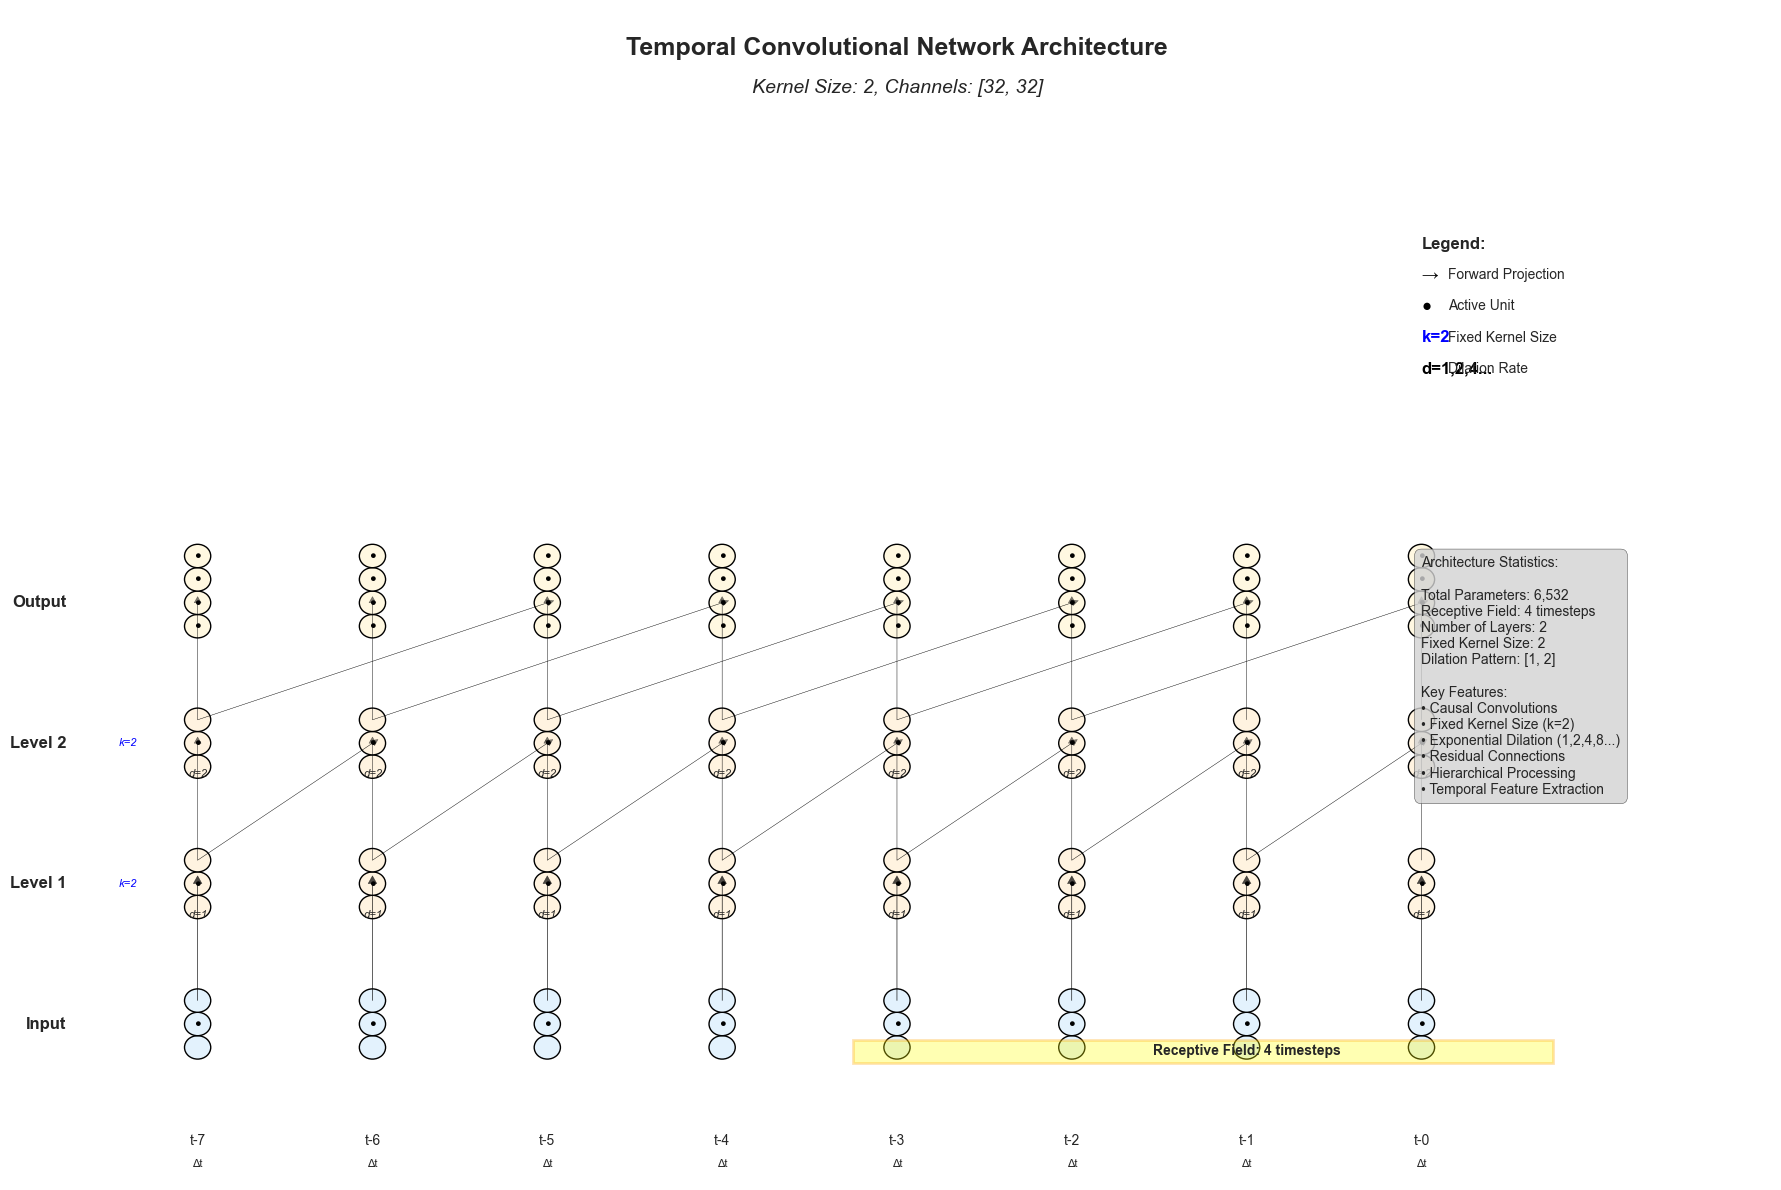

Architecture Statistics:
• Total Parameters: 6,532
• Receptive Field: 4 timesteps
• Dilation Pattern: [1, 2]

Training TCN with kernel_size=2, channels=[32, 32]
Learning rate: 0.001, Epochs: 20, Batch size: 32
Generating ECG dataset...
ECG Signal Examples:


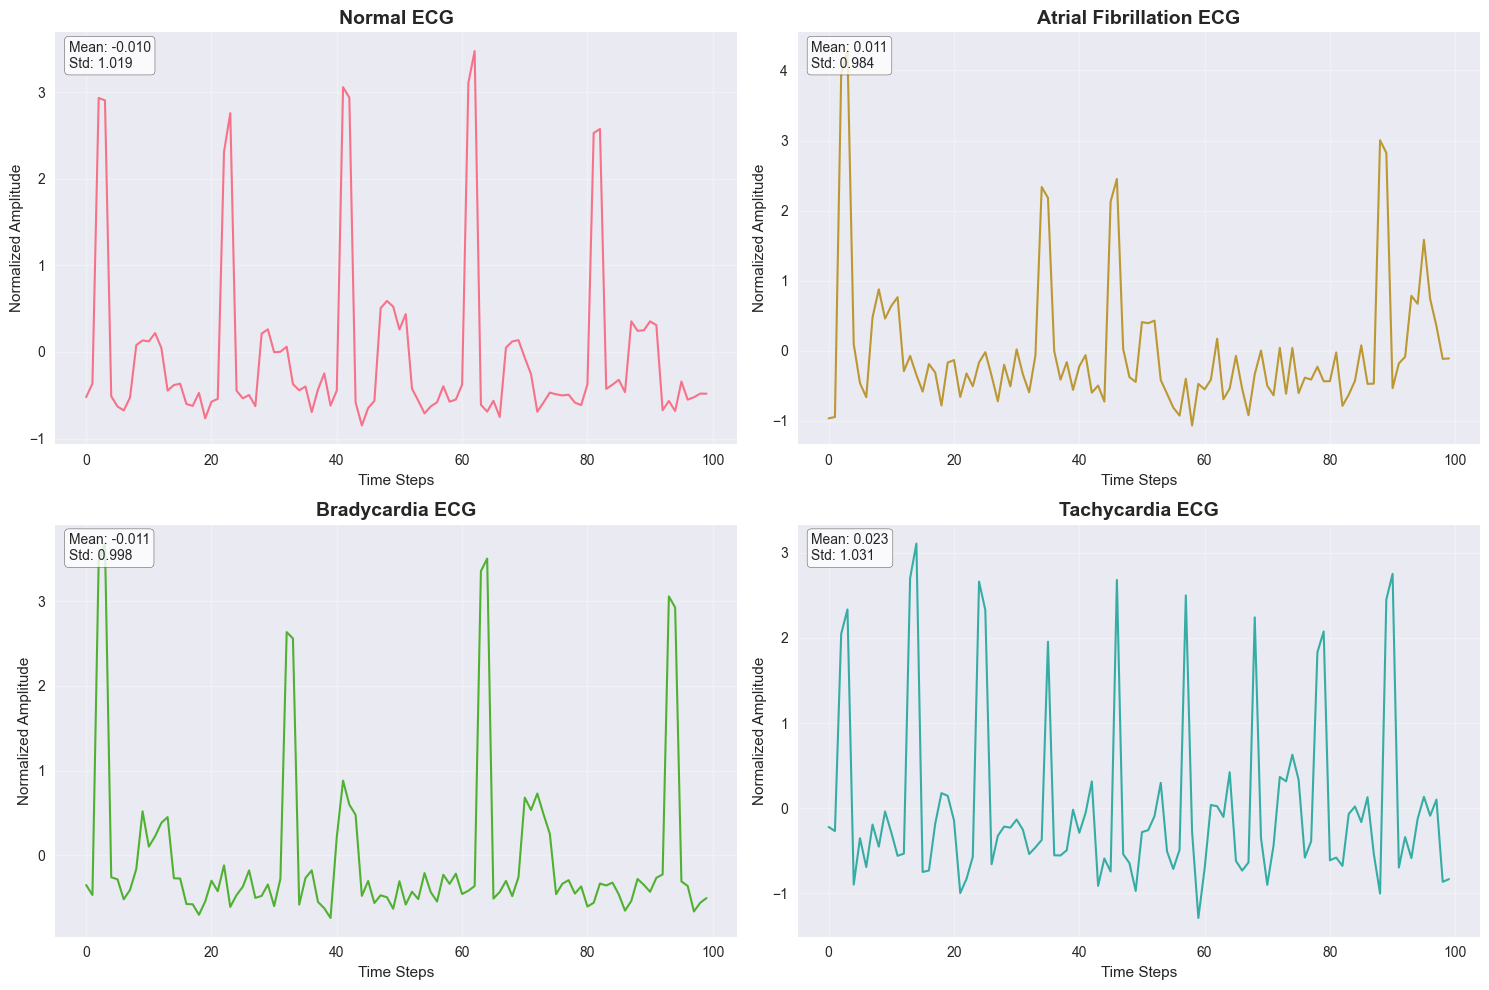


Class Distribution:
  Normal: 250 samples (25.0%)
  Atrial Fibrillation: 250 samples (25.0%)
  Bradycardia: 250 samples (25.0%)
  Tachycardia: 250 samples (25.0%)
  Total: 1000 samples

Data Split Verification:
Normal: Train 200 (25.0%), Val 50 (25.0%)
Atrial Fibrillation: Train 200 (25.0%), Val 50 (25.0%)
Bradycardia: Train 200 (25.0%), Val 50 (25.0%)
Tachycardia: Train 200 (25.0%), Val 50 (25.0%)

Starting training...
Epoch [5/20] - Train Loss: 1.3865, Train Acc: 24.50% - Val Loss: 1.3863, Val Acc: 25.00%
Epoch [10/20] - Train Loss: 1.3873, Train Acc: 24.62% - Val Loss: 1.3869, Val Acc: 25.00%
Epoch [15/20] - Train Loss: 1.3853, Train Acc: 25.88% - Val Loss: 1.3832, Val Acc: 49.00%
Epoch [20/20] - Train Loss: 1.3776, Train Acc: 36.75% - Val Loss: 1.3755, Val Acc: 49.00%

Training Debug Info:
Initial validation accuracy: 25.00%
Final validation accuracy: 49.00%
Accuracy improvement: 24.00%
Training Complete!
Final Training Accuracy: 36.75%
Final Validation Accuracy: 49.00%


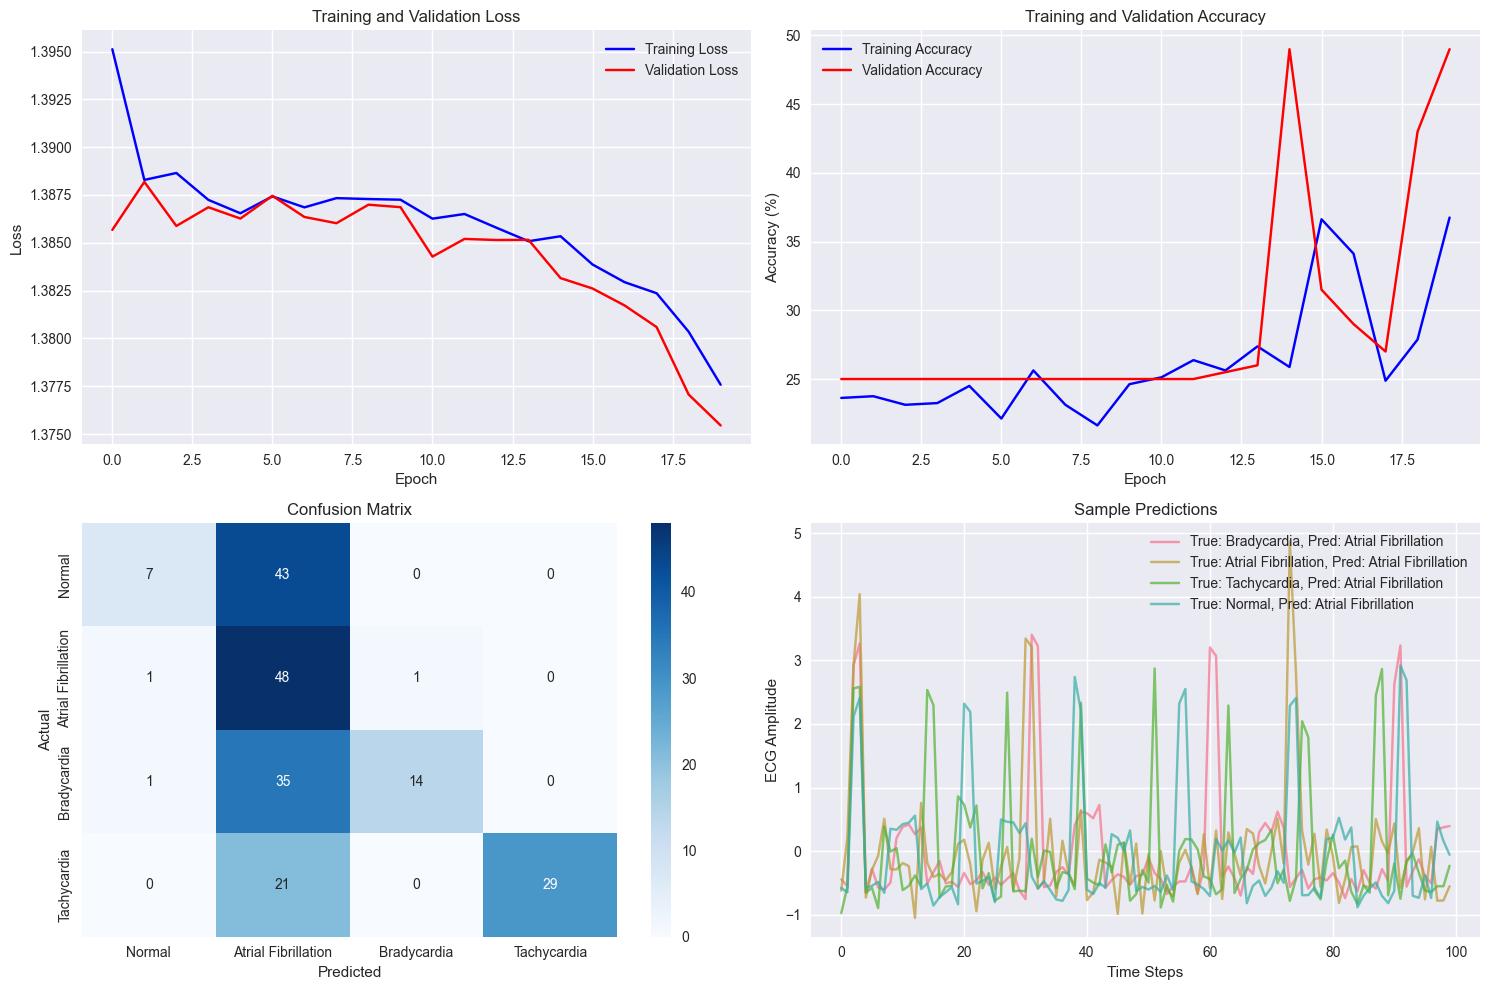

In [7]:
# Demo 1: Small kernel, shallow network
print("CONFIGURATION 1: Small Kernel (2), Shallow Network [32, 32]")
print("=" * 50)
model1, loss1, acc1, tracker1 = train_tcn_with_architecture(
    kernel_size=2, 
    num_channels=[32, 32], 
    epochs=20
)


CONFIGURATION 2: Larger Kernel (3), Deeper Network [64, 64, 64]
TCN ARCHITECTURE VISUALIZATION


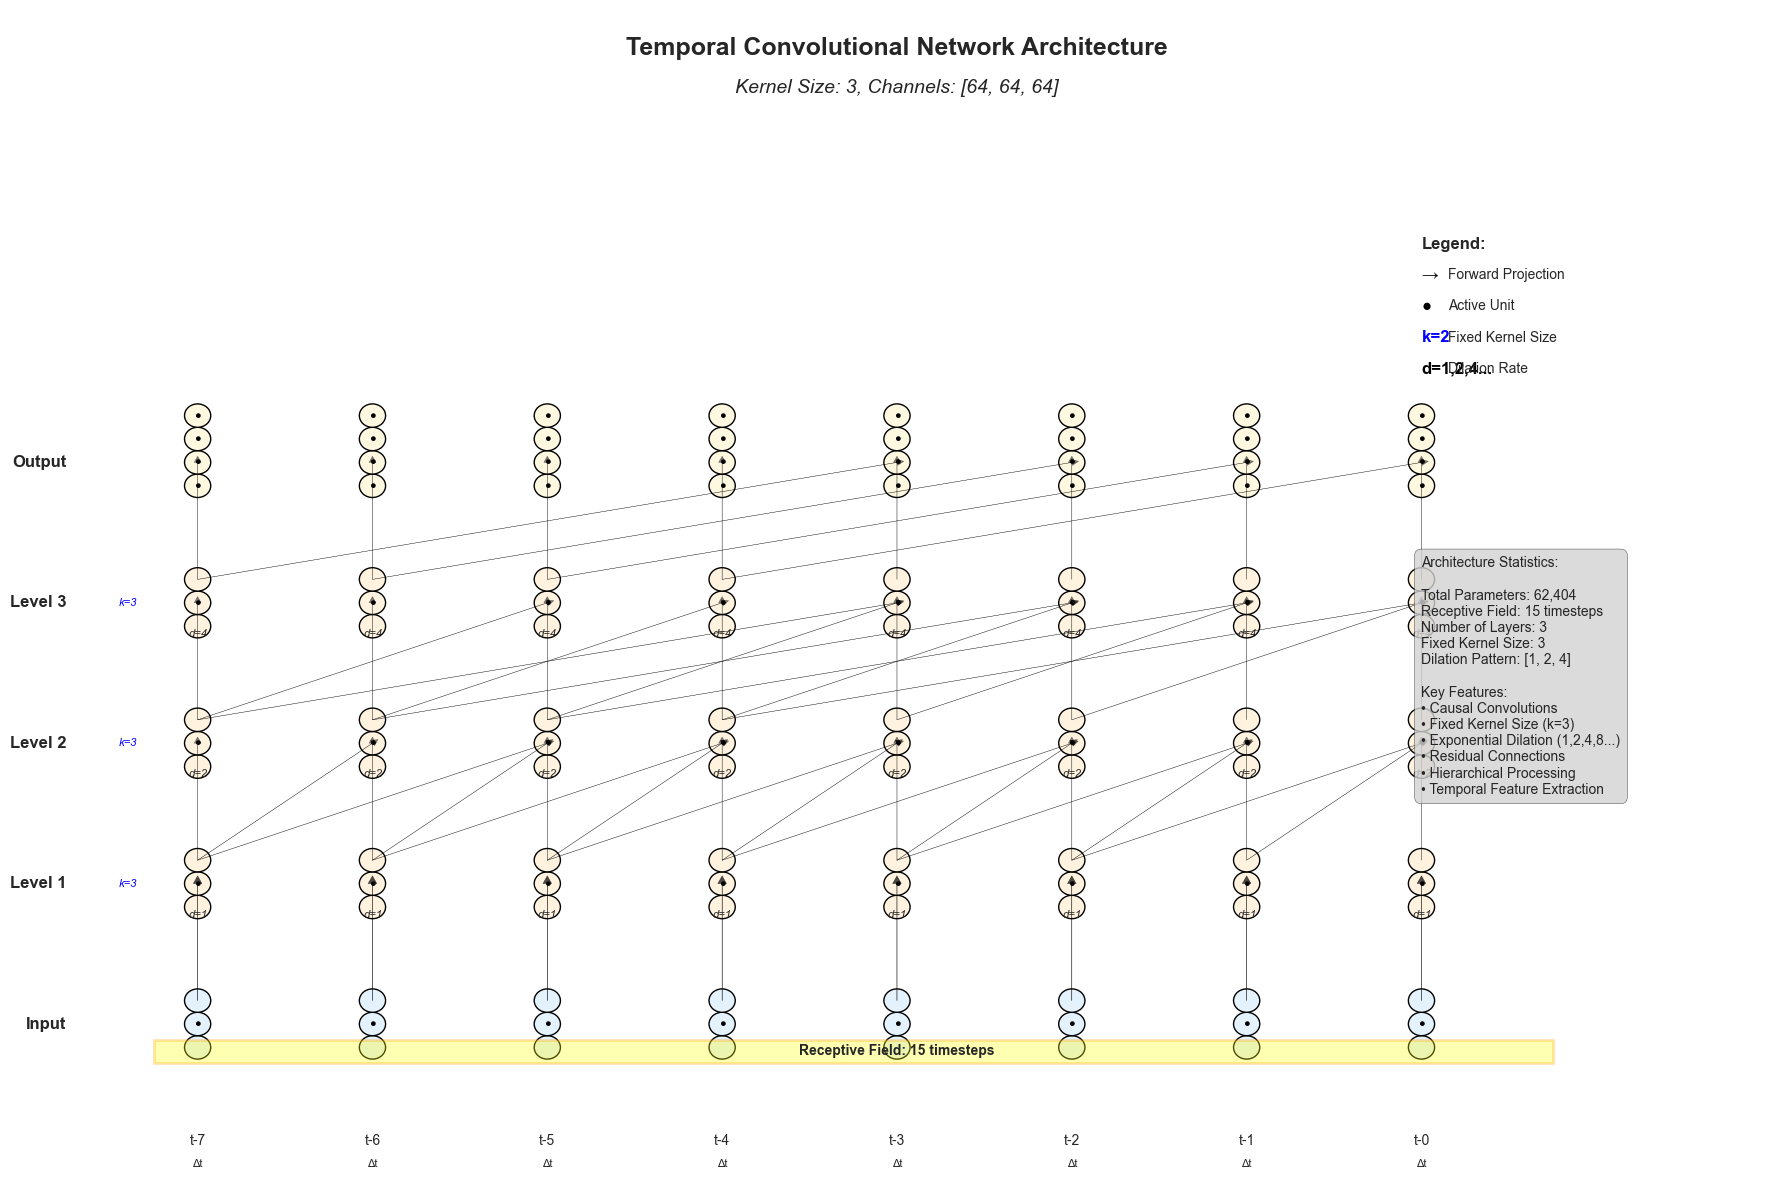

Architecture Statistics:
• Total Parameters: 62,404
• Receptive Field: 15 timesteps
• Dilation Pattern: [1, 2, 4]

Training TCN with kernel_size=3, channels=[64, 64, 64]
Learning rate: 0.001, Epochs: 20, Batch size: 32
Generating ECG dataset...
ECG Signal Examples:


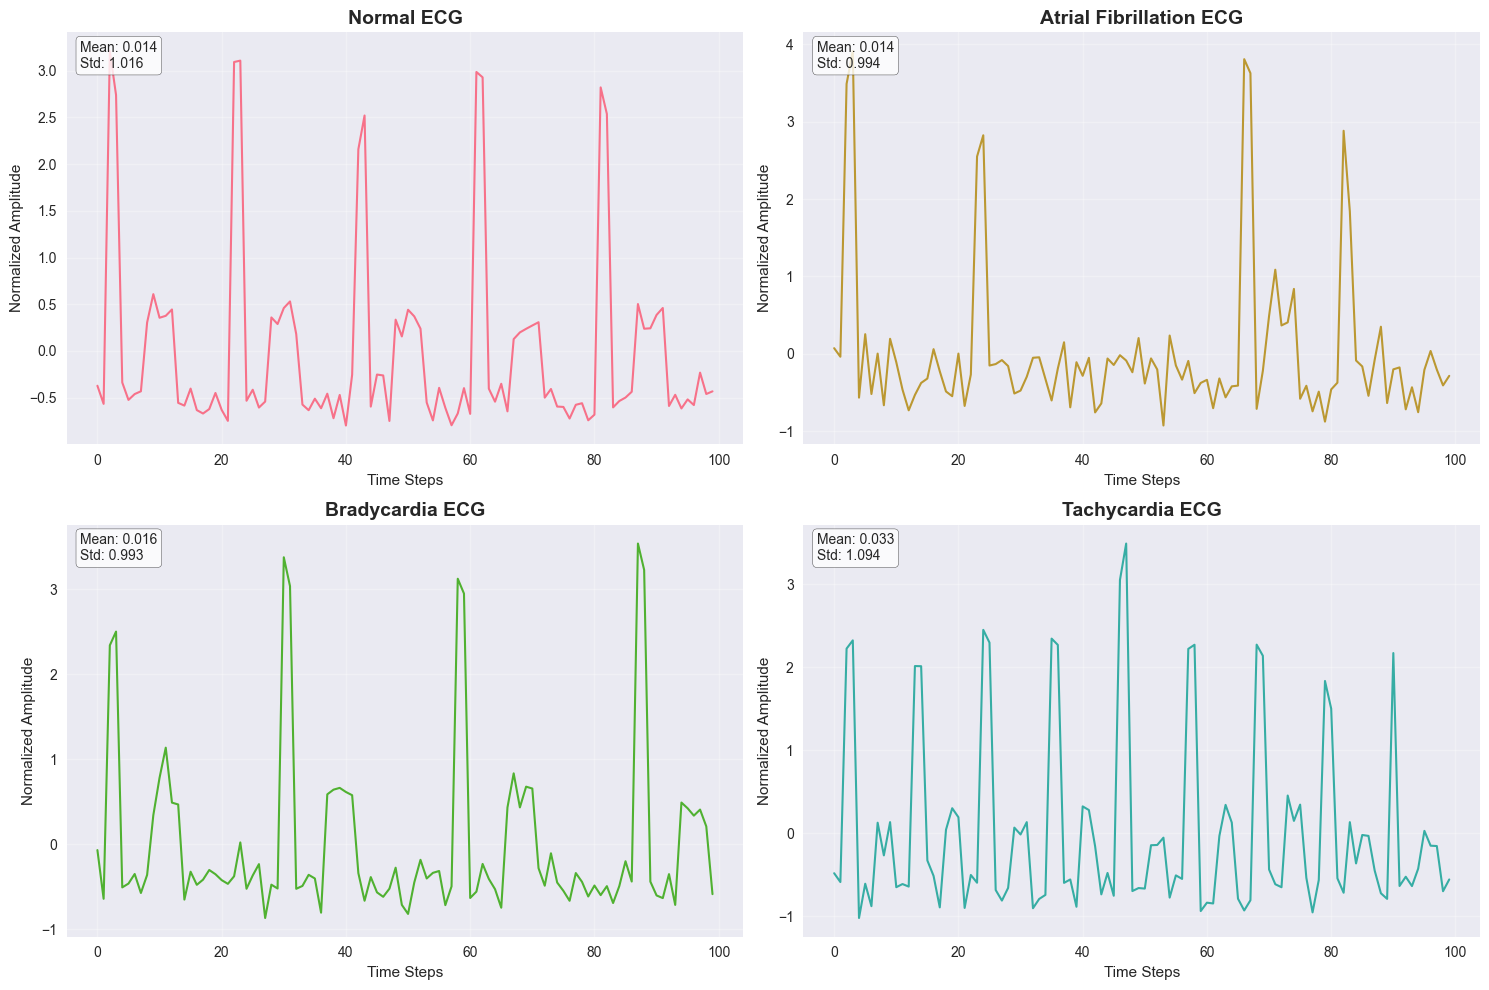


Class Distribution:
  Normal: 250 samples (25.0%)
  Atrial Fibrillation: 250 samples (25.0%)
  Bradycardia: 250 samples (25.0%)
  Tachycardia: 250 samples (25.0%)
  Total: 1000 samples

Data Split Verification:
Normal: Train 200 (25.0%), Val 50 (25.0%)
Atrial Fibrillation: Train 200 (25.0%), Val 50 (25.0%)
Bradycardia: Train 200 (25.0%), Val 50 (25.0%)
Tachycardia: Train 200 (25.0%), Val 50 (25.0%)

Starting training...
Epoch [5/20] - Train Loss: 1.3841, Train Acc: 27.38% - Val Loss: 1.3811, Val Acc: 25.00%
Epoch [10/20] - Train Loss: 1.3407, Train Acc: 43.88% - Val Loss: 1.3229, Val Acc: 47.50%
Epoch [15/20] - Train Loss: 0.2071, Train Acc: 93.00% - Val Loss: 0.2353, Val Acc: 91.00%
Epoch [20/20] - Train Loss: 0.1057, Train Acc: 96.50% - Val Loss: 0.0904, Val Acc: 97.50%

Training Debug Info:
Initial validation accuracy: 25.00%
Final validation accuracy: 97.50%
Accuracy improvement: 72.50%
Training Complete!
Final Training Accuracy: 96.50%
Final Validation Accuracy: 97.50%


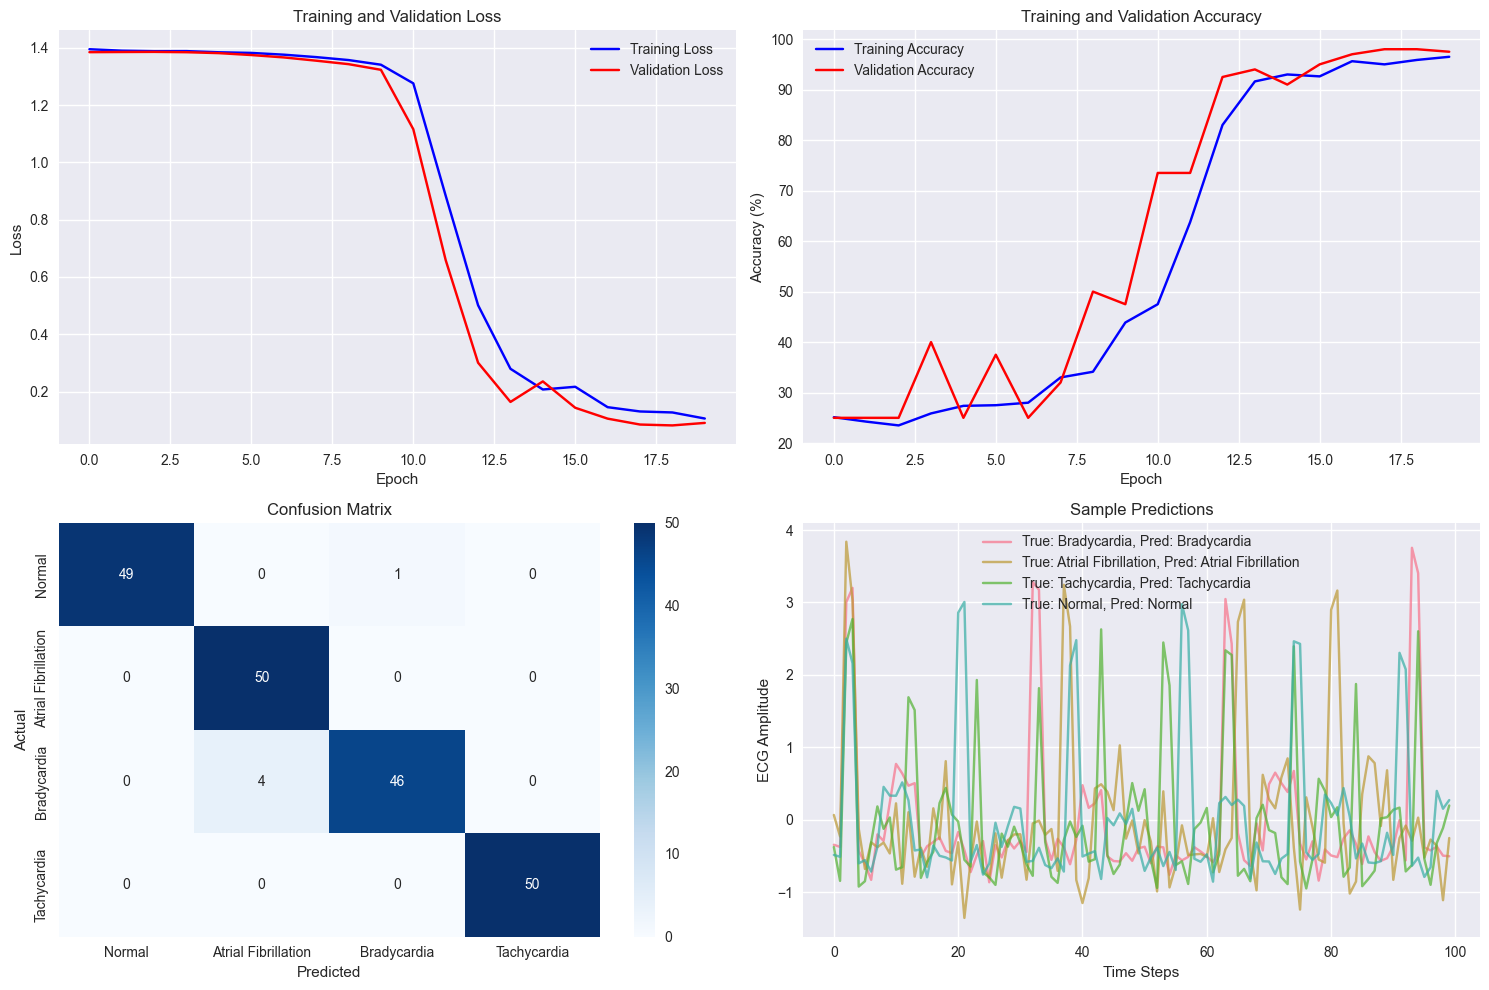

In [8]:
# Demo 2: Larger kernel, deeper network
print("CONFIGURATION 2: Larger Kernel (3), Deeper Network [64, 64, 64]")
print("=" * 50)
model2, loss2, acc2, tracker2 = train_tcn_with_architecture(
    kernel_size=3, 
    num_channels=[64, 64, 64], 
    epochs=20
)


CONFIGURATION 3: Large Kernel (5), Very Deep Network [128, 128, 128, 128]
TCN ARCHITECTURE VISUALIZATION


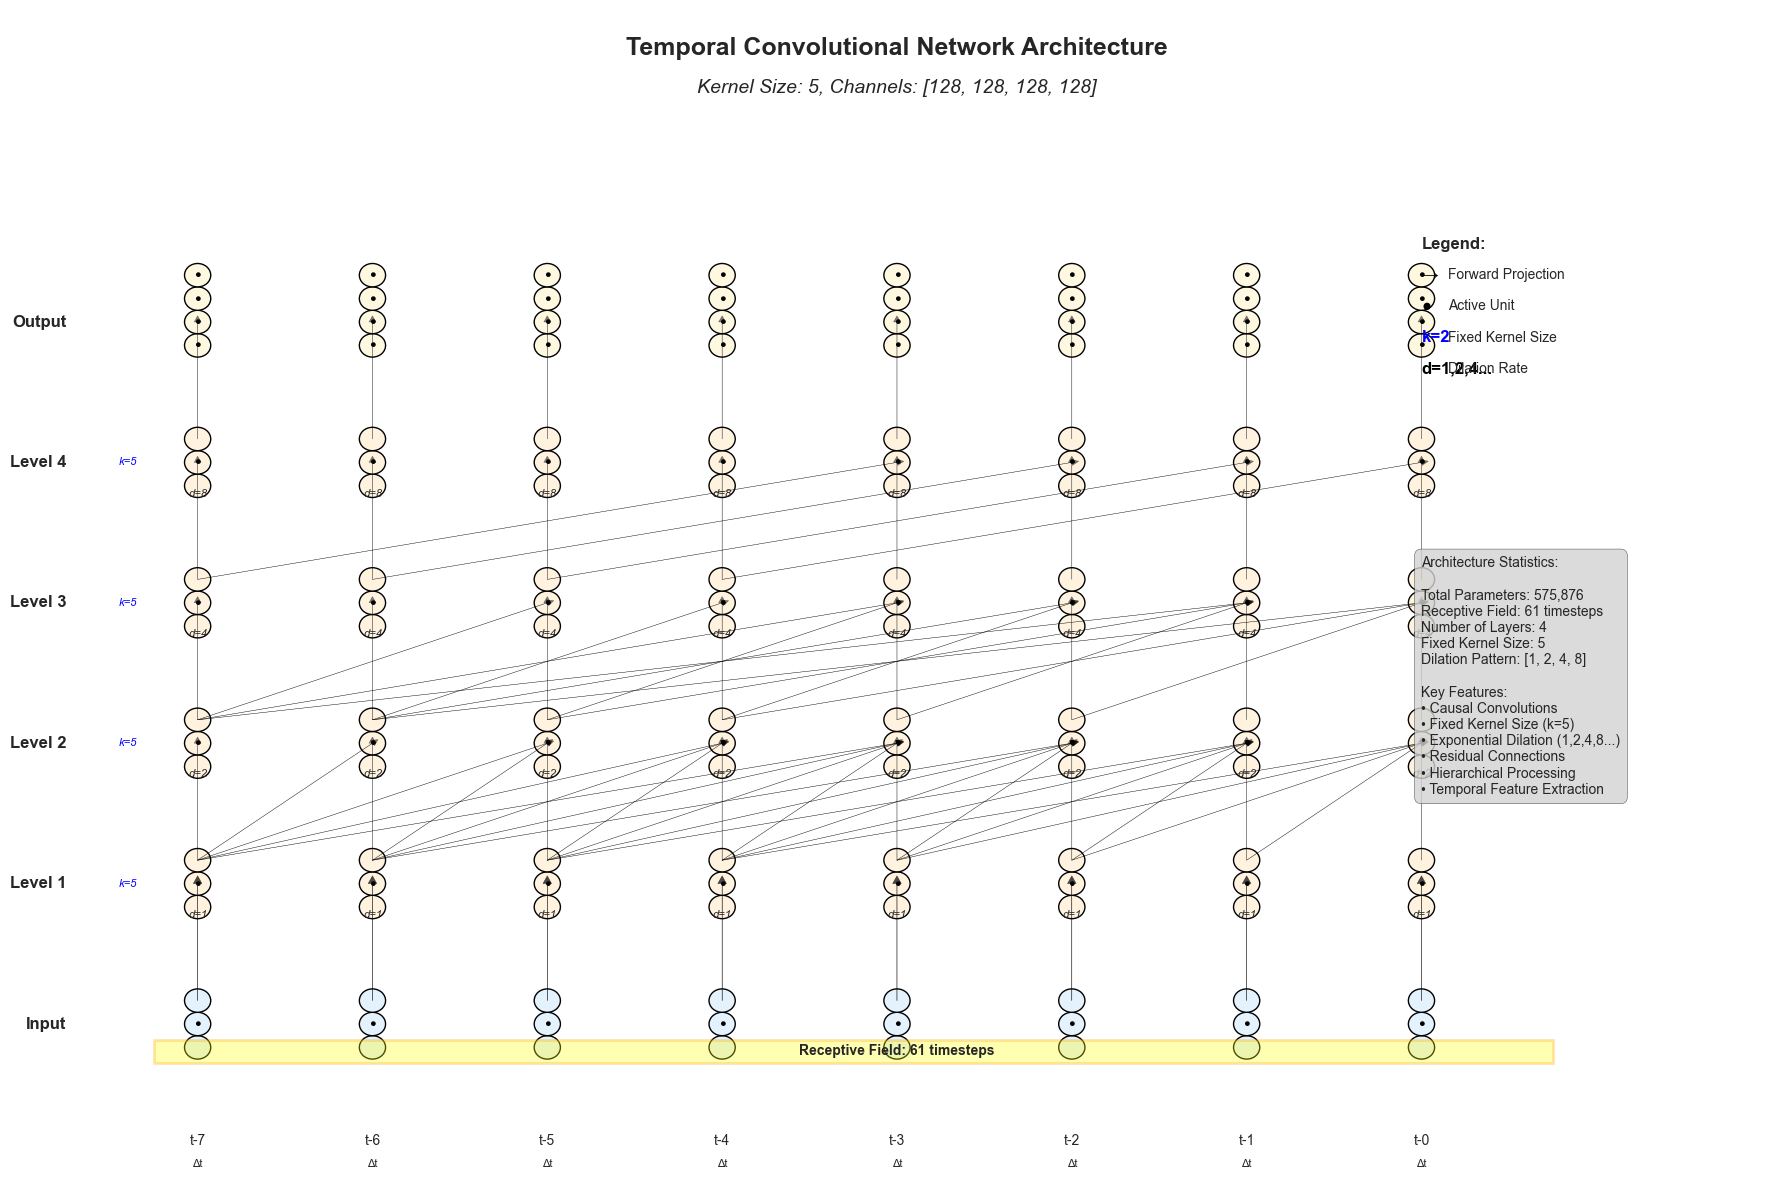

Architecture Statistics:
• Total Parameters: 575,876
• Receptive Field: 61 timesteps
• Dilation Pattern: [1, 2, 4, 8]

Training TCN with kernel_size=5, channels=[128, 128, 128, 128]
Learning rate: 0.001, Epochs: 20, Batch size: 32
Generating ECG dataset...
ECG Signal Examples:


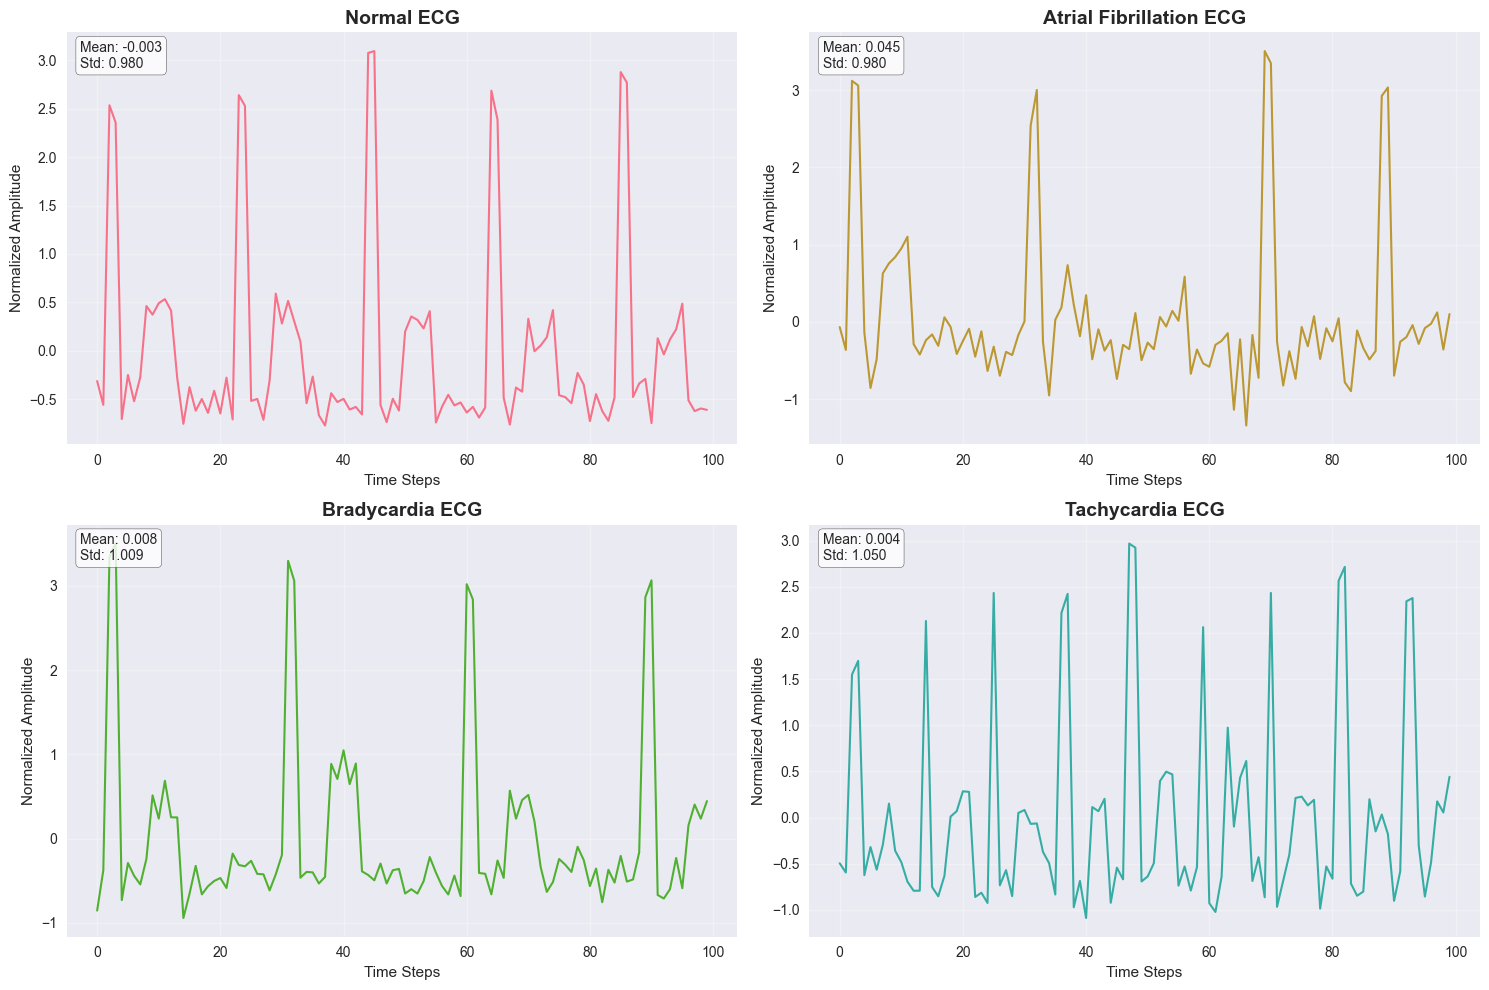


Class Distribution:
  Normal: 250 samples (25.0%)
  Atrial Fibrillation: 250 samples (25.0%)
  Bradycardia: 250 samples (25.0%)
  Tachycardia: 250 samples (25.0%)
  Total: 1000 samples

Data Split Verification:
Normal: Train 200 (25.0%), Val 50 (25.0%)
Atrial Fibrillation: Train 200 (25.0%), Val 50 (25.0%)
Bradycardia: Train 200 (25.0%), Val 50 (25.0%)
Tachycardia: Train 200 (25.0%), Val 50 (25.0%)

Starting training...
Epoch [5/20] - Train Loss: 0.9150, Train Acc: 56.25% - Val Loss: 0.7346, Val Acc: 67.00%
Epoch [10/20] - Train Loss: 0.4957, Train Acc: 78.00% - Val Loss: 0.4177, Val Acc: 82.50%
Epoch [15/20] - Train Loss: 0.2042, Train Acc: 92.75% - Val Loss: 0.1432, Val Acc: 93.50%
Epoch [20/20] - Train Loss: 0.0801, Train Acc: 97.00% - Val Loss: 0.4641, Val Acc: 86.00%

Training Debug Info:
Initial validation accuracy: 25.00%
Final validation accuracy: 86.00%
Accuracy improvement: 61.00%
Training Complete!
Final Training Accuracy: 97.00%
Final Validation Accuracy: 86.00%


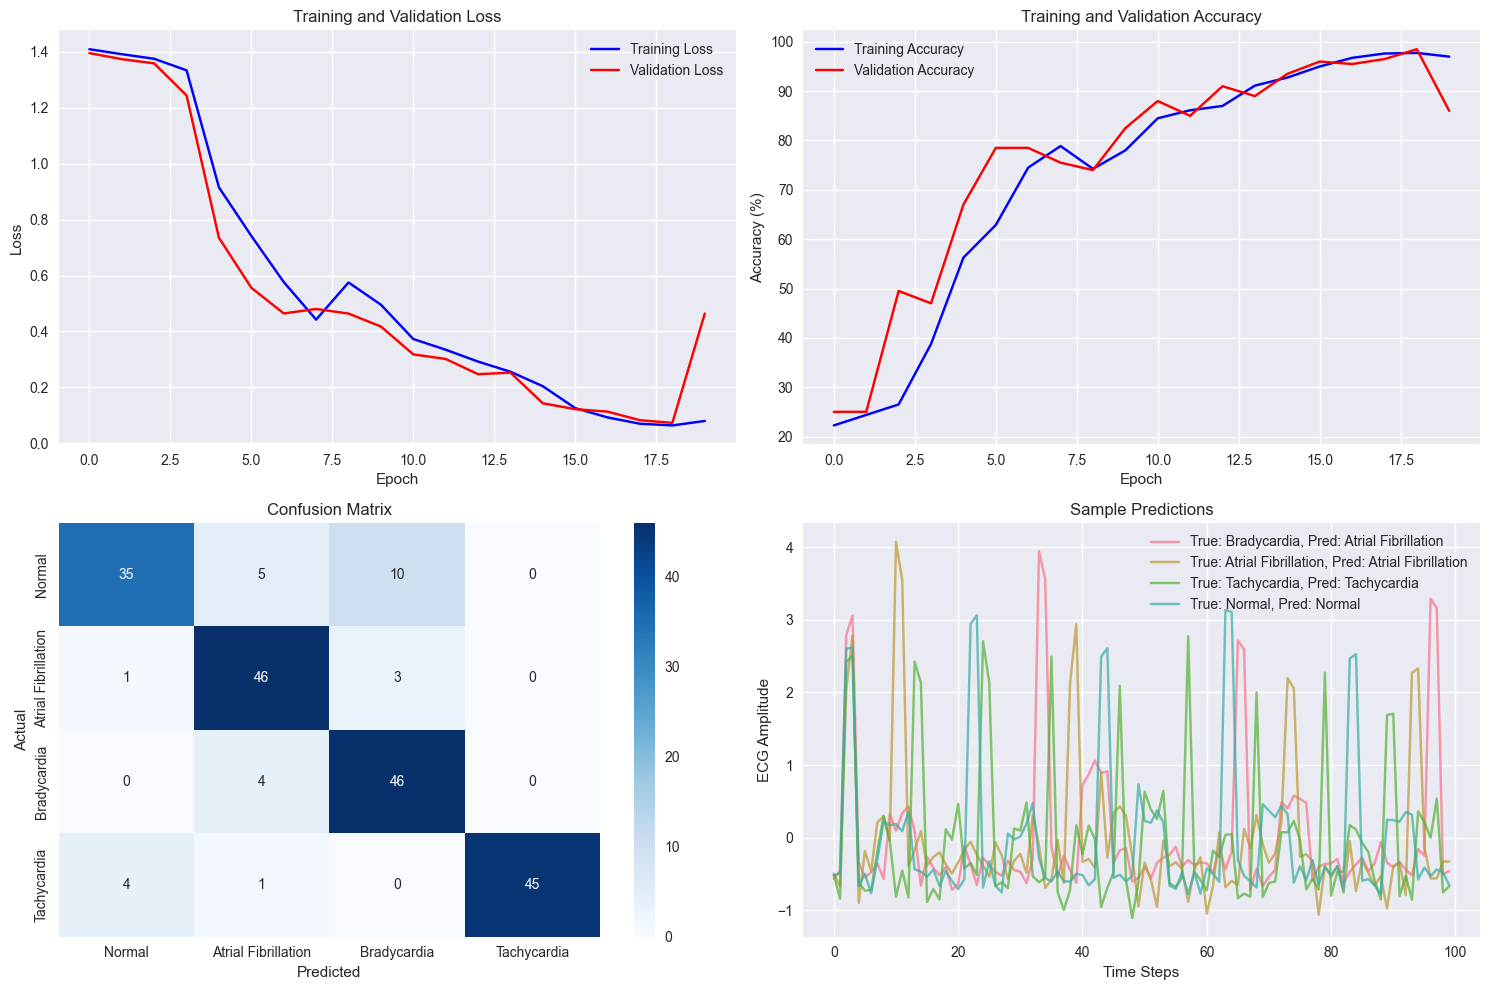

In [9]:
# Demo 3: Very large kernel, very deep network
print("CONFIGURATION 3: Large Kernel (5), Very Deep Network [128, 128, 128, 128]")
print("=" * 50)
model3, loss3, acc3, tracker3 = train_tcn_with_architecture(
    kernel_size=5, 
    num_channels=[128, 128, 128, 128], 
    epochs=20
)


PERFORMANCE COMPARISON (WITH RESIDUAL CONNECTIONS)
Configuration 1 (k=2, [32,32]):     Validation Accuracy: 49.00%
Configuration 2 (k=3, [64,64,64]):  Validation Accuracy: 97.50%
Configuration 3 (k=5, [128,128,128,128]): Validation Accuracy: 86.00%


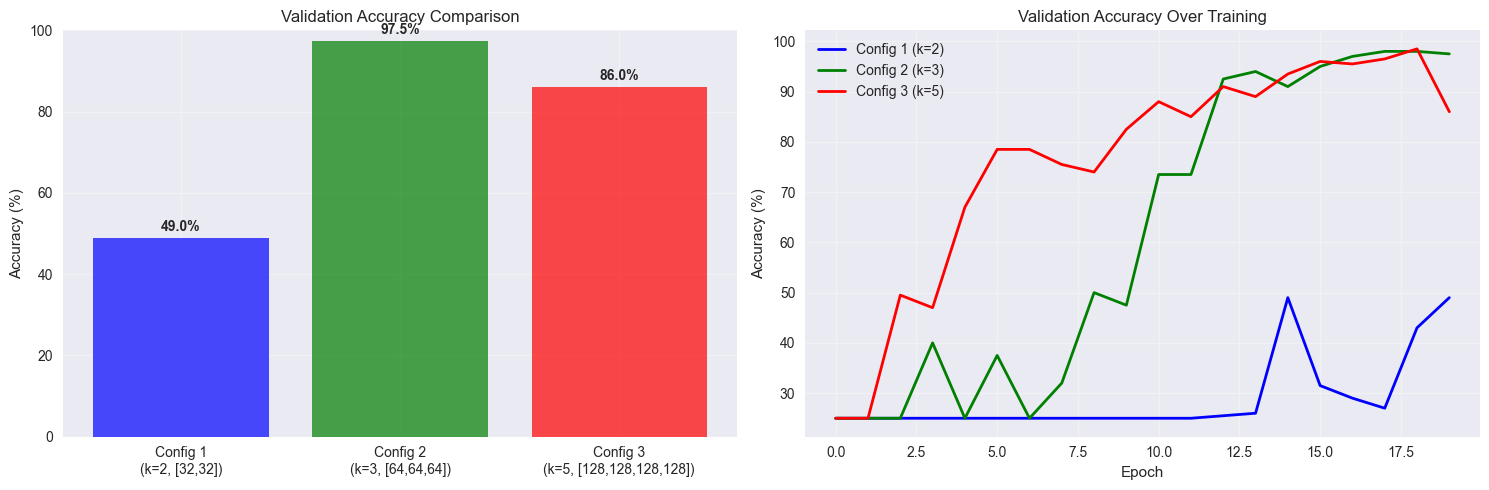


Key Observations:
• Larger kernels capture longer temporal dependencies
• Deeper networks have more capacity but may overfit
• TCNs with exponential dilation efficiently process long sequences
• Architecture choice depends on data complexity and sequence length


In [10]:
# Compare Results (WITH Residual Connections)
print("=" * 60)
print("PERFORMANCE COMPARISON (WITH RESIDUAL CONNECTIONS)")
print("=" * 60)
print(f"Configuration 1 (k=2, [32,32]):     Validation Accuracy: {acc1:.2f}%")
print(f"Configuration 2 (k=3, [64,64,64]):  Validation Accuracy: {acc2:.2f}%")
print(f"Configuration 3 (k=5, [128,128,128,128]): Validation Accuracy: {acc3:.2f}%")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
configs = ['Config 1\n(k=2, [32,32])', 'Config 2\n(k=3, [64,64,64])', 'Config 3\n(k=5, [128,128,128,128])']
accs = [acc1, acc2, acc3]
colors = ['blue', 'green', 'red']

bars = ax1.bar(configs, accs, color=colors, alpha=0.7)
ax1.set_title('Validation Accuracy Comparison')
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Training curves comparison
ax2.plot(tracker1['val_accs'], label='Config 1 (k=2)', color='blue', linewidth=2)
ax2.plot(tracker2['val_accs'], label='Config 2 (k=3)', color='green', linewidth=2)
ax2.plot(tracker3['val_accs'], label='Config 3 (k=5)', color='red', linewidth=2)
ax2.set_title('Validation Accuracy Over Training')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Larger kernels capture longer temporal dependencies")
print("• Deeper networks have more capacity but may overfit")
print("• TCNs with exponential dilation efficiently process long sequences")
print("• Architecture choice depends on data complexity and sequence length")


## 6. Residual Connection Comparison

Let's compare the performance with and without residual connections to see the impact.


In [11]:
# Create TCN without residual connections for comparison
class TemporalBlockNoResidual(nn.Module):
    """Temporal Block for TCN WITHOUT residual connections."""
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding):
        super(TemporalBlockNoResidual, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, 
                              padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride,
                              padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1,
                                self.conv2, self.chomp2, self.relu2)
        
        self.init_weights()
        
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
            
    def forward(self, x):
        return self.net(x)

class TCNNoResidual(nn.Module):
    """Temporal Convolutional Network WITHOUT residual connections."""
    def __init__(self, num_inputs, num_channels, num_classes, kernel_size=2):
        super(TCNNoResidual, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            
            layers += [TemporalBlockNoResidual(in_channels, out_channels, kernel_size, stride=1,
                                             dilation=dilation_size, padding=padding)]
        
        self.network = nn.Sequential(*layers)
        self.classifier = nn.Linear(num_channels[-1], num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, num_inputs)
        x = x.transpose(1, 2)  # (batch_size, num_inputs, sequence_length)
        y = self.network(x)
        # Global average pooling
        y = y.mean(dim=2)  # (batch_size, num_channels[-1])
        return self.classifier(y)

# Training function for TCN without residual connections
def train_tcn_no_residual_with_architecture(kernel_size=2, num_channels=[64, 64], learning_rate=0.001, 
                                          epochs=30, batch_size=32, show_plots=True):
    """Train TCN model WITHOUT residual connections with architecture visualization."""
    conditions = ['Normal', 'Atrial Fibrillation', 'Bradycardia', 'Tachycardia']
    
    # Show architecture visualization first (WITHOUT residual connections)
    print("=" * 60)
    print("TCN ARCHITECTURE VISUALIZATION (NO RESIDUAL CONNECTIONS)")
    print("=" * 60)
    visualizer = TCNArchitectureVisualizer()
    arch_fig = visualizer.visualize_tcn_architecture(1, num_channels, len(conditions), kernel_size, has_residual=False)
    plt.show()
    
    # Print architecture statistics
    total_params = visualizer.calculate_parameters(1, num_channels, len(conditions), kernel_size, has_residual=False)
    receptive_field = visualizer.calculate_receptive_field(kernel_size, len(num_channels))
    print(f"Architecture Statistics:")
    print(f"• Total Parameters: {total_params:,}")
    print(f"• Receptive Field: {receptive_field} timesteps")
    print(f"• Dilation Pattern: {[2**i for i in range(len(num_channels))]}")
    print()
    
    # Now train the model
    return train_tcn_no_residual(kernel_size, num_channels, learning_rate, epochs, batch_size, show_plots)

print("TCN without residual connections implemented!")


TCN without residual connections implemented!


In [12]:
# Training function for TCN without residual connections
def train_tcn_no_residual(kernel_size=2, num_channels=[64, 64], learning_rate=0.001, 
                         epochs=30, batch_size=32, show_plots=True):
    """Train TCN model WITHOUT residual connections."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    conditions = ['Normal', 'Atrial Fibrillation', 'Bradycardia', 'Tachycardia']
    
    print(f"Training TCN WITHOUT residual connections")
    print(f"Kernel size: {kernel_size}, channels: {num_channels}")
    print(f"Learning rate: {learning_rate}, Epochs: {epochs}, Batch size: {batch_size}")
    print("=" * 60)
    
    # Generate data
    print("Generating ECG dataset...")
    X, y = create_ecg_dataset(num_samples=1000, sequence_length=100, show_examples=False)
    
    # Add feature dimension for TCN input
    X = X.reshape(X.shape[0], X.shape[1], 1)  # (num_samples, sequence_length, 1)
    
    # Split data with proper stratification
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    X_val = torch.FloatTensor(X_val)
    y_train = torch.LongTensor(y_train)
    y_val = torch.LongTensor(y_val)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model WITHOUT residual connections
    model = TCNNoResidual(num_inputs=1, num_channels=num_channels, num_classes=4, kernel_size=kernel_size)
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training tracking
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    print("Starting training...")
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        
        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% - Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Final results
    print("=" * 60)
    print("Training Complete (NO RESIDUAL CONNECTIONS)!")
    print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
    
    return model, val_losses[-1], val_accs[-1], {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

print("Training function for TCN without residual connections ready!")


Training function for TCN without residual connections ready!


RESIDUAL CONNECTION COMPARISON
Testing configuration: kernel_size=2, channels=[128, 128, 128, 128]

1. Training WITH Residual Connections:
----------------------------------------
TCN ARCHITECTURE VISUALIZATION


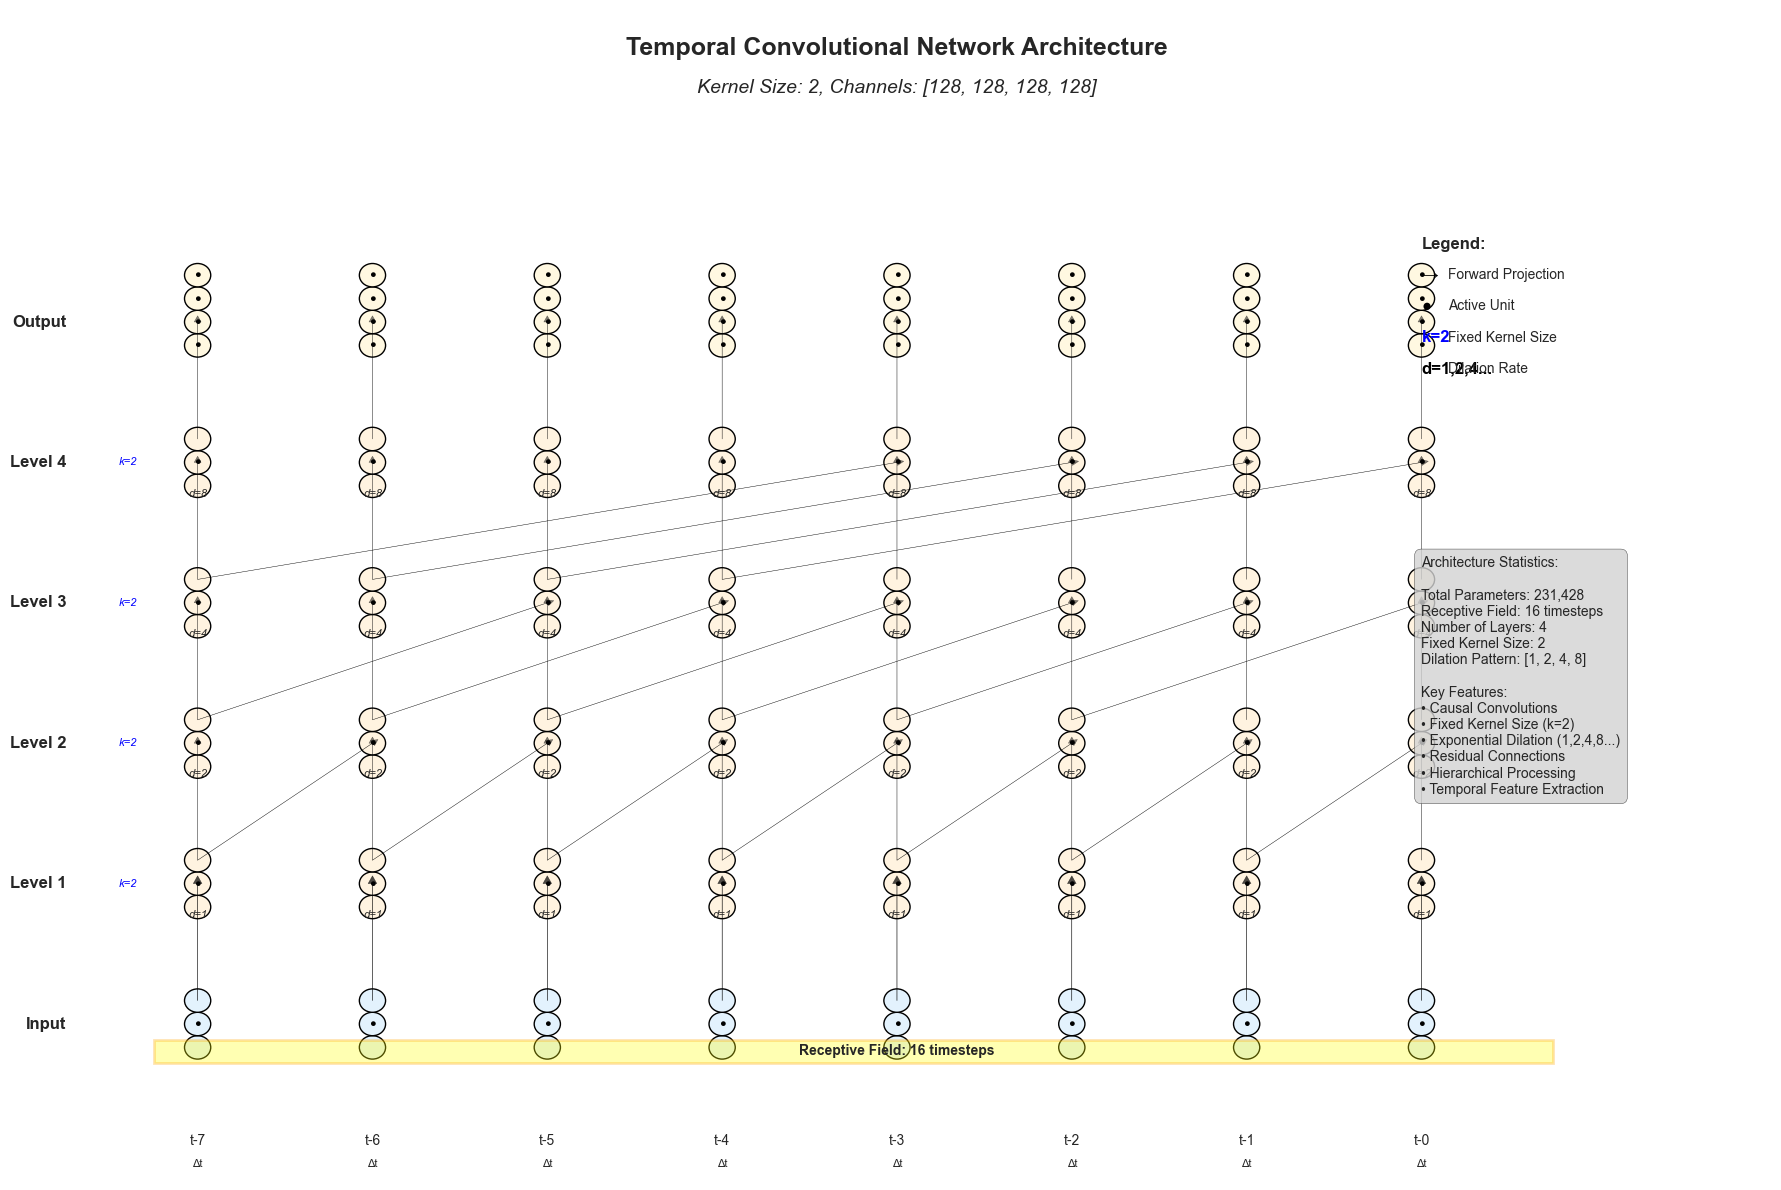

Architecture Statistics:
• Total Parameters: 231,428
• Receptive Field: 16 timesteps
• Dilation Pattern: [1, 2, 4, 8]

Training TCN with kernel_size=2, channels=[128, 128, 128, 128]
Learning rate: 0.001, Epochs: 20, Batch size: 32
Generating ECG dataset...
ECG Signal Examples:


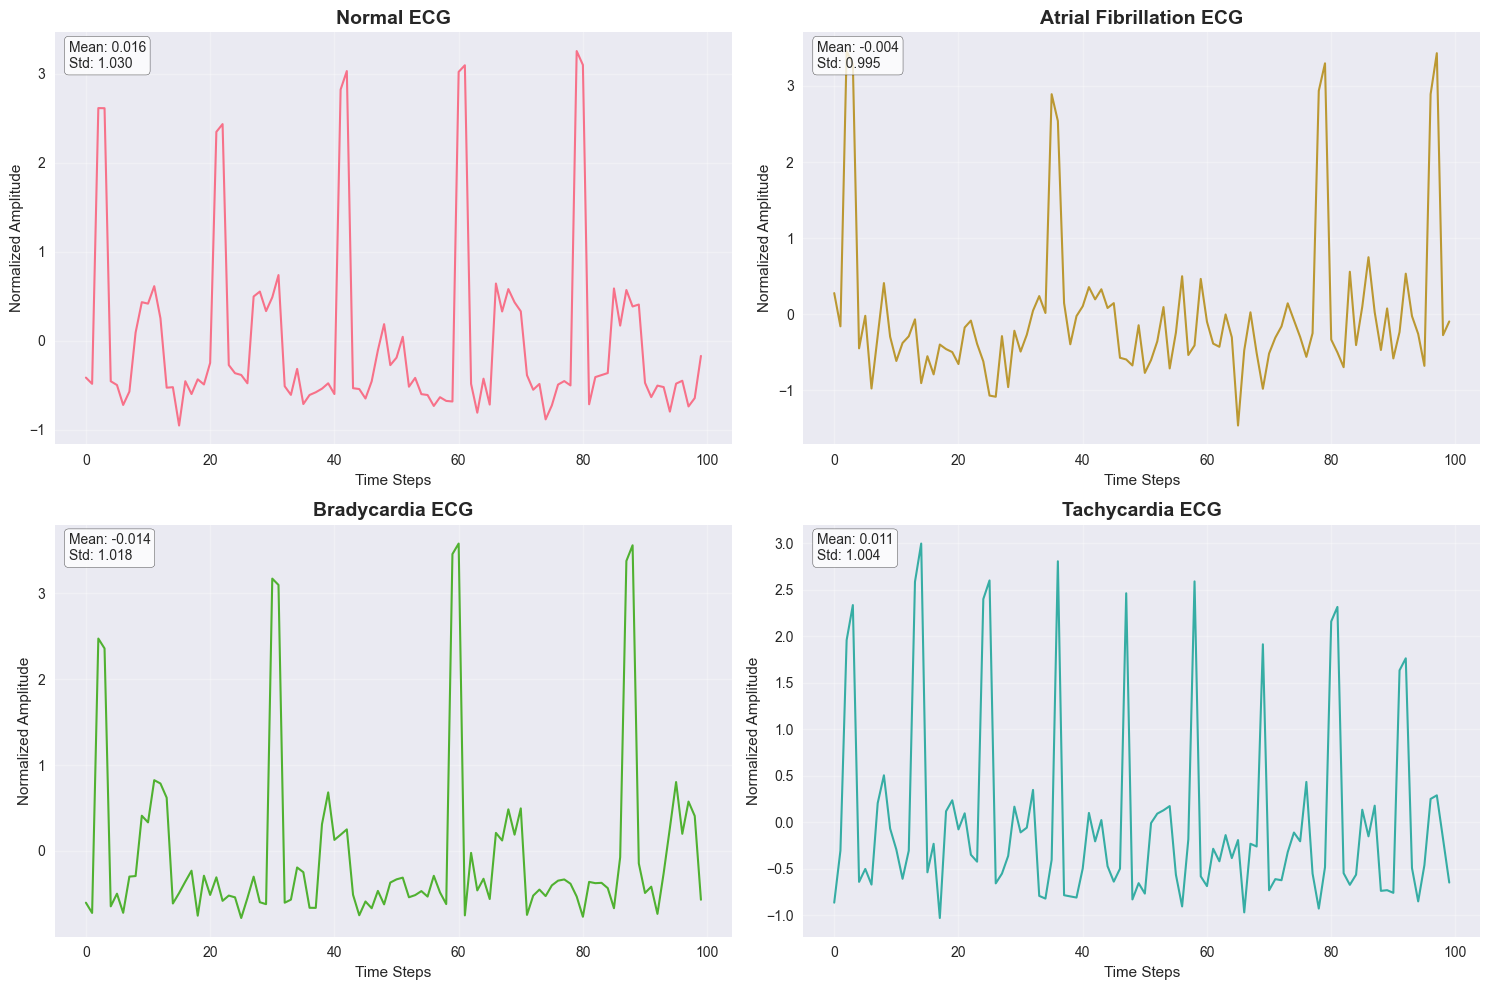


Class Distribution:
  Normal: 250 samples (25.0%)
  Atrial Fibrillation: 250 samples (25.0%)
  Bradycardia: 250 samples (25.0%)
  Tachycardia: 250 samples (25.0%)
  Total: 1000 samples

Data Split Verification:
Normal: Train 200 (25.0%), Val 50 (25.0%)
Atrial Fibrillation: Train 200 (25.0%), Val 50 (25.0%)
Bradycardia: Train 200 (25.0%), Val 50 (25.0%)
Tachycardia: Train 200 (25.0%), Val 50 (25.0%)

Starting training...
Epoch [5/20] - Train Loss: 1.3868, Train Acc: 25.12% - Val Loss: 1.3728, Val Acc: 29.00%
Epoch [10/20] - Train Loss: 0.8637, Train Acc: 60.88% - Val Loss: 0.6112, Val Acc: 72.50%
Epoch [15/20] - Train Loss: 0.1527, Train Acc: 95.00% - Val Loss: 0.0944, Val Acc: 98.50%
Epoch [20/20] - Train Loss: 0.1539, Train Acc: 93.75% - Val Loss: 0.0638, Val Acc: 99.00%

Training Debug Info:
Initial validation accuracy: 25.00%
Final validation accuracy: 99.00%
Accuracy improvement: 74.00%
Training Complete!
Final Training Accuracy: 93.75%
Final Validation Accuracy: 99.00%


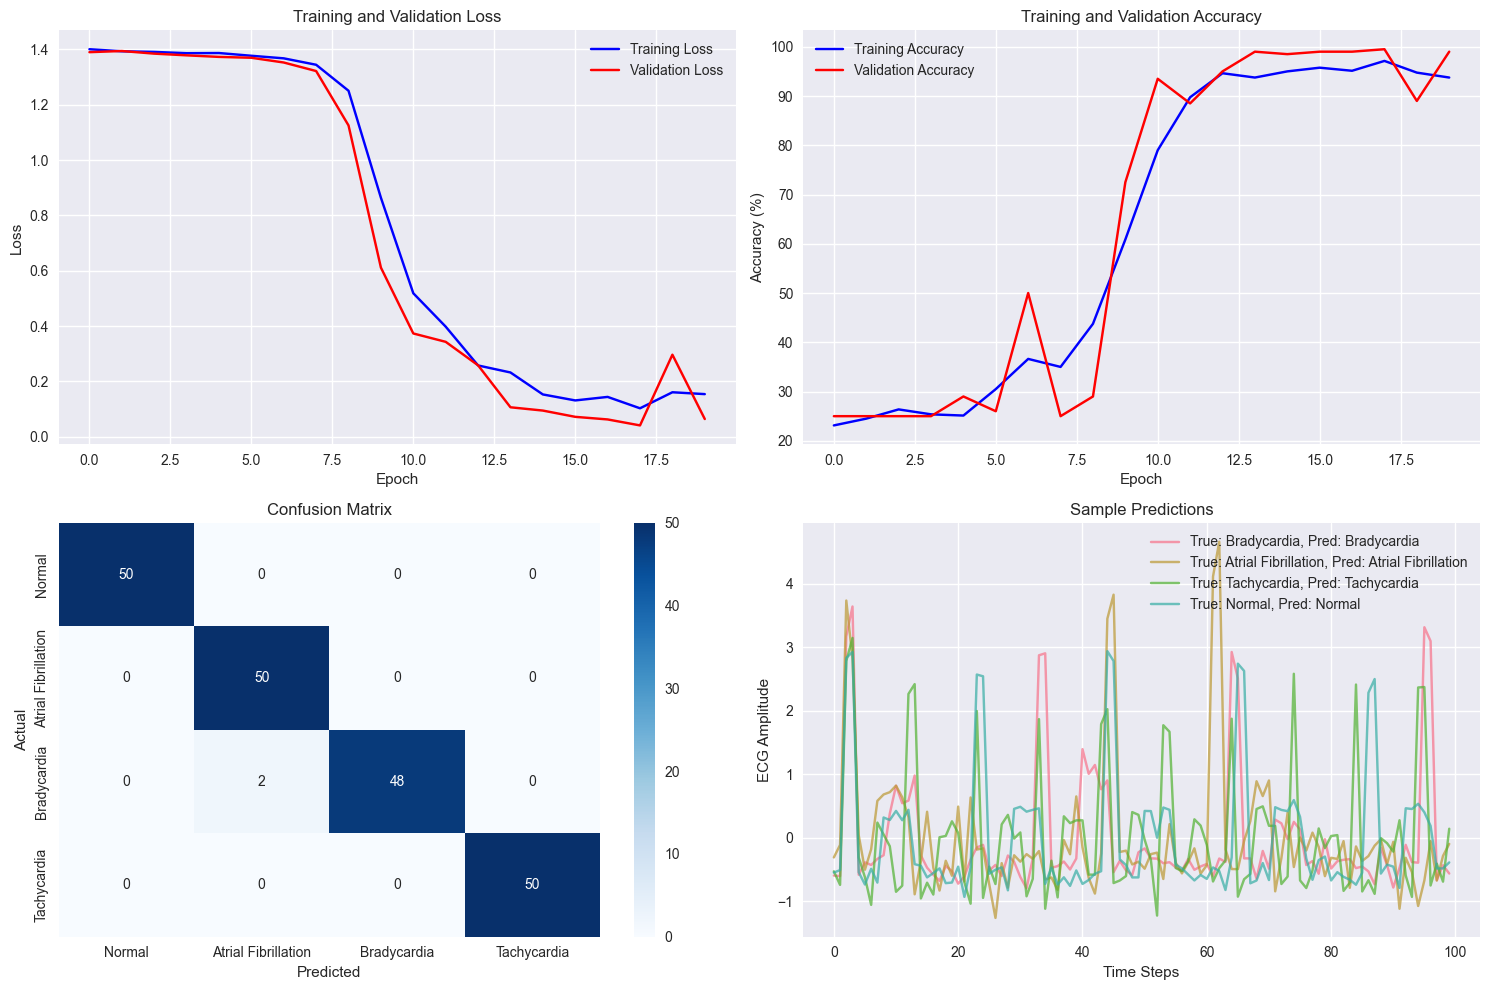



2. Training WITHOUT Residual Connections:
----------------------------------------
TCN ARCHITECTURE VISUALIZATION (NO RESIDUAL CONNECTIONS)


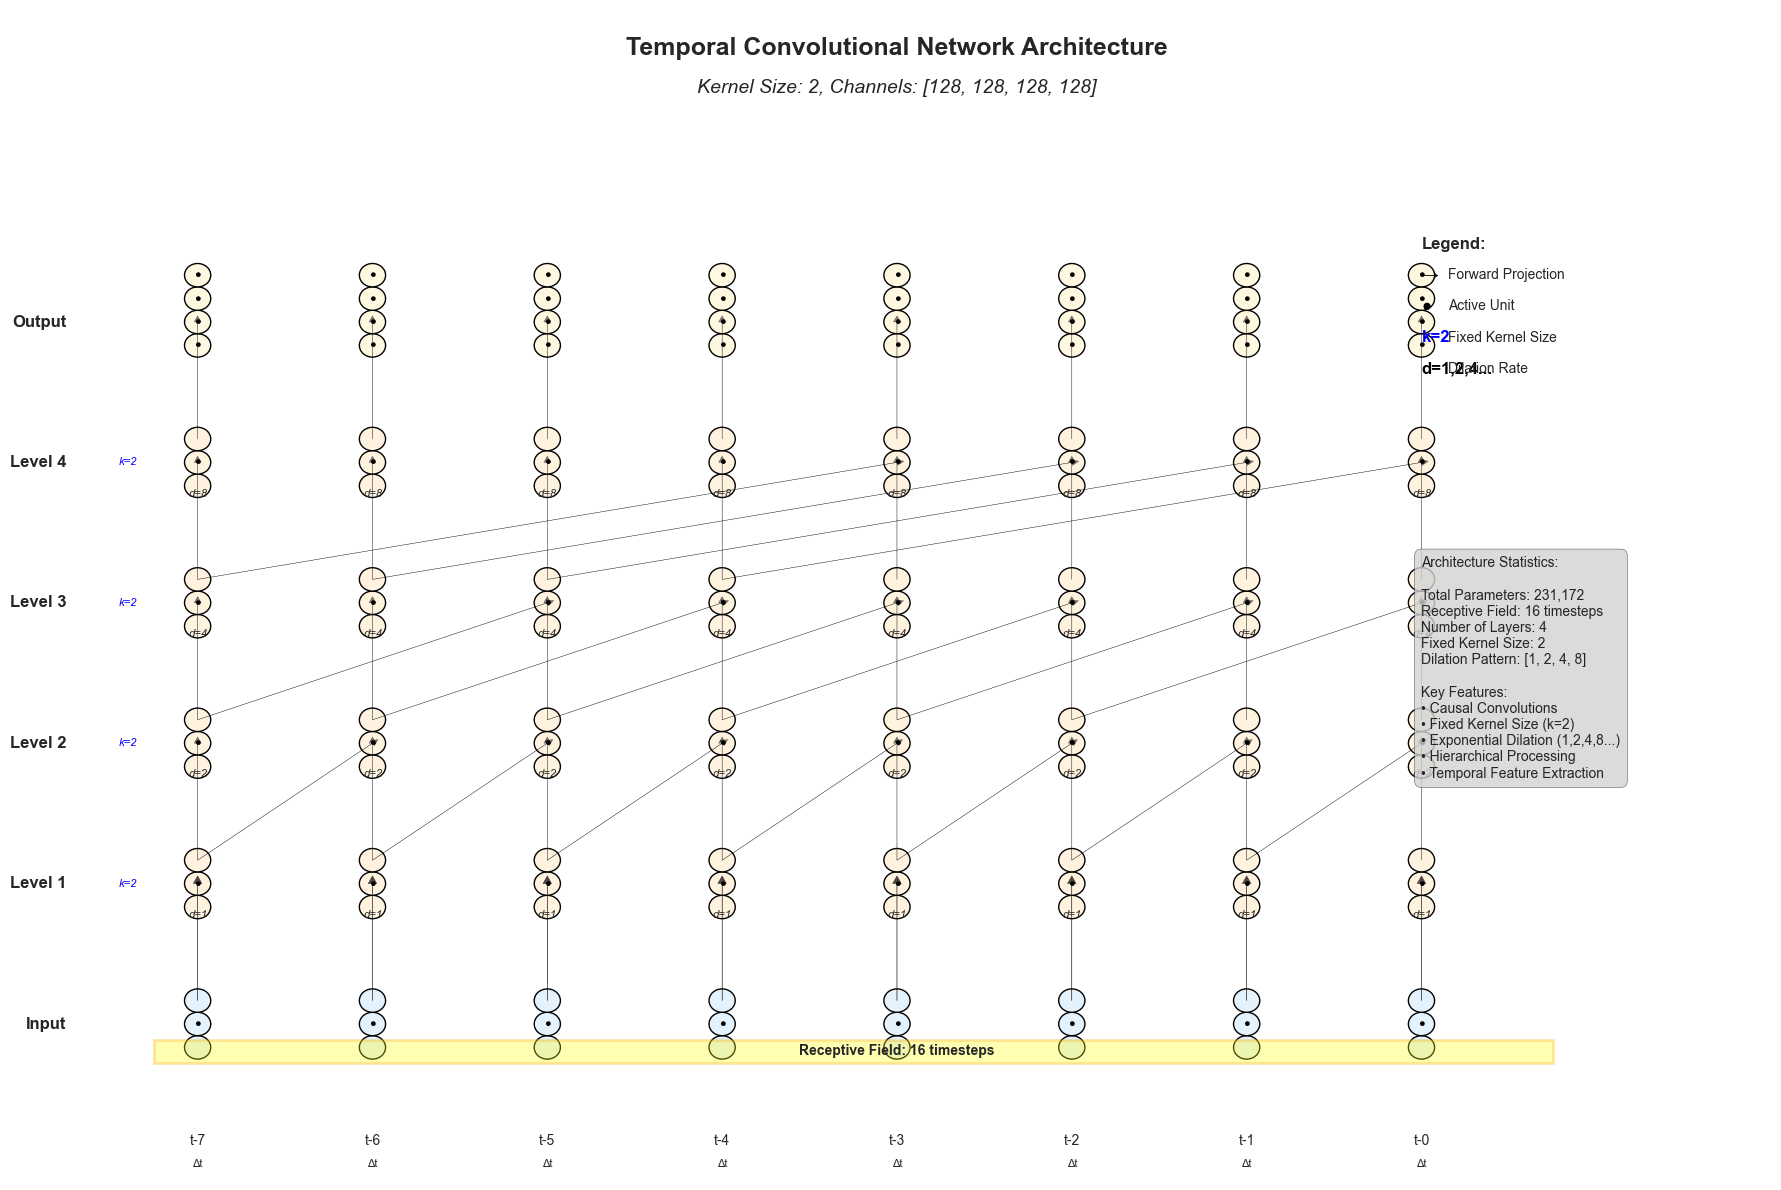

Architecture Statistics:
• Total Parameters: 231,172
• Receptive Field: 16 timesteps
• Dilation Pattern: [1, 2, 4, 8]

Training TCN WITHOUT residual connections
Kernel size: 2, channels: [128, 128, 128, 128]
Learning rate: 0.001, Epochs: 20, Batch size: 32
Generating ECG dataset...
Starting training...
Epoch [5/20] - Train Loss: 1.3866, Train Acc: 25.00% - Val Loss: 1.3865, Val Acc: 25.00%
Epoch [10/20] - Train Loss: 1.3866, Train Acc: 23.50% - Val Loss: 1.3866, Val Acc: 25.00%
Epoch [15/20] - Train Loss: 1.3865, Train Acc: 25.00% - Val Loss: 1.3861, Val Acc: 25.00%
Epoch [20/20] - Train Loss: 1.3867, Train Acc: 24.38% - Val Loss: 1.3865, Val Acc: 25.00%
Training Complete (NO RESIDUAL CONNECTIONS)!
Final Training Accuracy: 24.38%
Final Validation Accuracy: 25.00%

FINAL COMPARISON RESULTS
WITH Residual Connections:    Validation Accuracy: 99.00%
WITHOUT Residual Connections: Validation Accuracy: 25.00%
Improvement from Residual:    74.00%


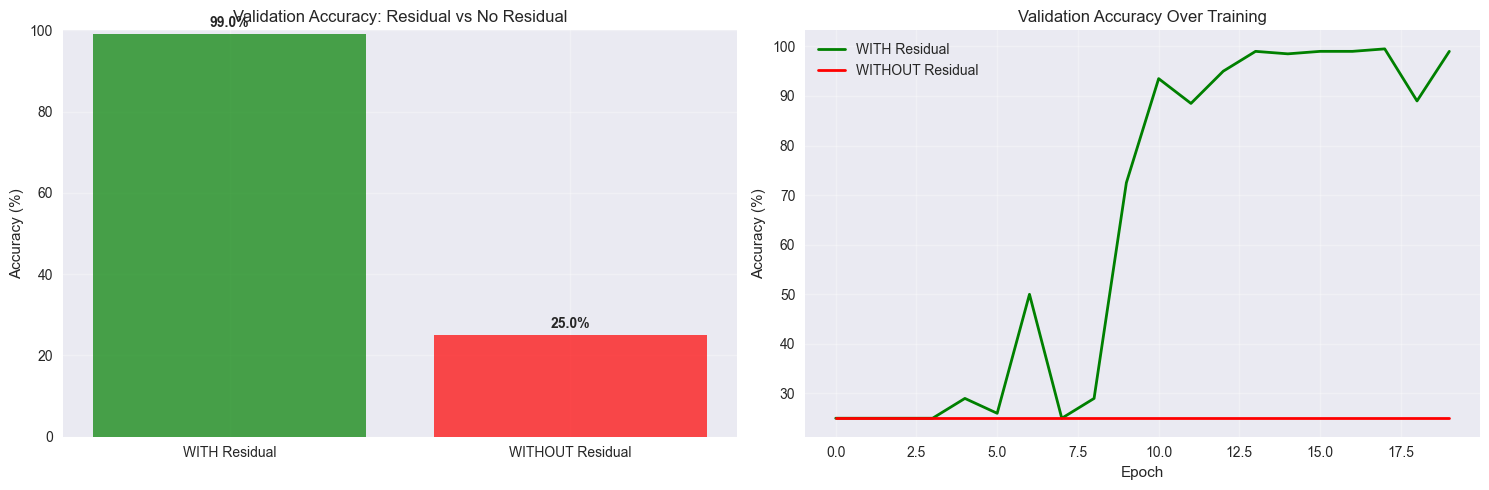


Key Insights:
✅ Residual connections IMPROVE performance!
   Improvement: 74.00%

Why Residual Connections Help:
• Enable deeper networks by solving vanishing gradient problem
• Allow direct gradient flow from output to input layers
• Help preserve information through skip connections
• Enable training of very deep networks (100+ layers)
• Improve convergence speed and final performance


In [13]:
# Compare WITH vs WITHOUT Residual Connections
print("=" * 70)
print("RESIDUAL CONNECTION COMPARISON")
print("=" * 70)

# Test configuration
kernel_size = 2
num_channels = [128, 128, 128, 128]
epochs = 20

print(f"Testing configuration: kernel_size={kernel_size}, channels={num_channels}")
print()

# Train WITH residual connections
print("1. Training WITH Residual Connections:")
print("-" * 40)
model_with_res, loss_with_res, acc_with_res, tracker_with_res = train_tcn_with_architecture(
    kernel_size=kernel_size, 
    num_channels=num_channels, 
    epochs=epochs
)

print("\n" + "="*50 + "\n")

# Train WITHOUT residual connections  
print("2. Training WITHOUT Residual Connections:")
print("-" * 40)
model_no_res, loss_no_res, acc_no_res, tracker_no_res = train_tcn_no_residual_with_architecture(
    kernel_size=kernel_size, 
    num_channels=num_channels, 
    epochs=epochs
)

# Compare results
print("\n" + "=" * 70)
print("FINAL COMPARISON RESULTS")
print("=" * 70)
print(f"WITH Residual Connections:    Validation Accuracy: {acc_with_res:.2f}%")
print(f"WITHOUT Residual Connections: Validation Accuracy: {acc_no_res:.2f}%")
print(f"Improvement from Residual:    {acc_with_res - acc_no_res:.2f}%")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
models = ['WITH Residual', 'WITHOUT Residual']
accs = [acc_with_res, acc_no_res]
colors = ['green', 'red']

bars = ax1.bar(models, accs, color=colors, alpha=0.7)
ax1.set_title('Validation Accuracy: Residual vs No Residual')
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Training curves comparison
ax2.plot(tracker_with_res['val_accs'], label='WITH Residual', color='green', linewidth=2)
ax2.plot(tracker_no_res['val_accs'], label='WITHOUT Residual', color='red', linewidth=2)
ax2.set_title('Validation Accuracy Over Training')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
if acc_with_res > acc_no_res:
    print("✅ Residual connections IMPROVE performance!")
    print(f"   Improvement: {acc_with_res - acc_no_res:.2f}%")
else:
    print("❌ Residual connections do NOT improve performance")
    print(f"   Difference: {acc_with_res - acc_no_res:.2f}%")

print("\nWhy Residual Connections Help:")
print("• Enable deeper networks by solving vanishing gradient problem")
print("• Allow direct gradient flow from output to input layers")
print("• Help preserve information through skip connections")
print("• Enable training of very deep networks (100+ layers)")
print("• Improve convergence speed and final performance")
